# Gaze estimation using Neural Networks
## Data preparation
This exercise focuses on using a multilayer perceptron (MLP) to estimate gaze using data collected in week 2 and processed in week 6 Data Preprocessing
.



---
**Task 1 (easy): Load the data 2👩‍💻**
1. Run the cell below to load the pupil coordinates from the file `pupil_coordinates.csv`
 and screen coordinates in the file `screen_coordinates.csv`
 for the `grid`
 pattern of `test_subject_1`
. The function `map_coordinates_to_targets`
 returns two $N \times 2$ arrays containing labels (screen coordinates) corresponding to the inputs (pupil coordinates). 


---

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import nn_util
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

test_subject = 'test_subject_1'
session = '20250820_T0'
pattern = 'grid'
file_name_pupil = f'../W02/sessions/{test_subject}/{session}/{pattern}/frames/pupil_coordinates.csv'
file_name_screen = f'../W02/sessions/{test_subject}/{session}/{pattern}/screen_coordinates.csv'

input, target = nn_util.load_coordinates(file_name_pupil)
labels = nn_util.map_targets_to_values(target, file_name_screen)

The data set is divided into training and test data using train_test_split
 function from scikit-learn.

---
**Task 2 (easy): Prepare data👩‍💻**
In the cell below:
1. Use the function `train_test_split`
 to split the input and target data into a $80\%/20\%$ train/test sets.
2. Use the function `train_test_split`
 to split the training into a $75\%/25\%$ train/validation sets.
3. Visualize the data using the function `plot_data_splits`
 from the `nn_util.py`
 file.


---

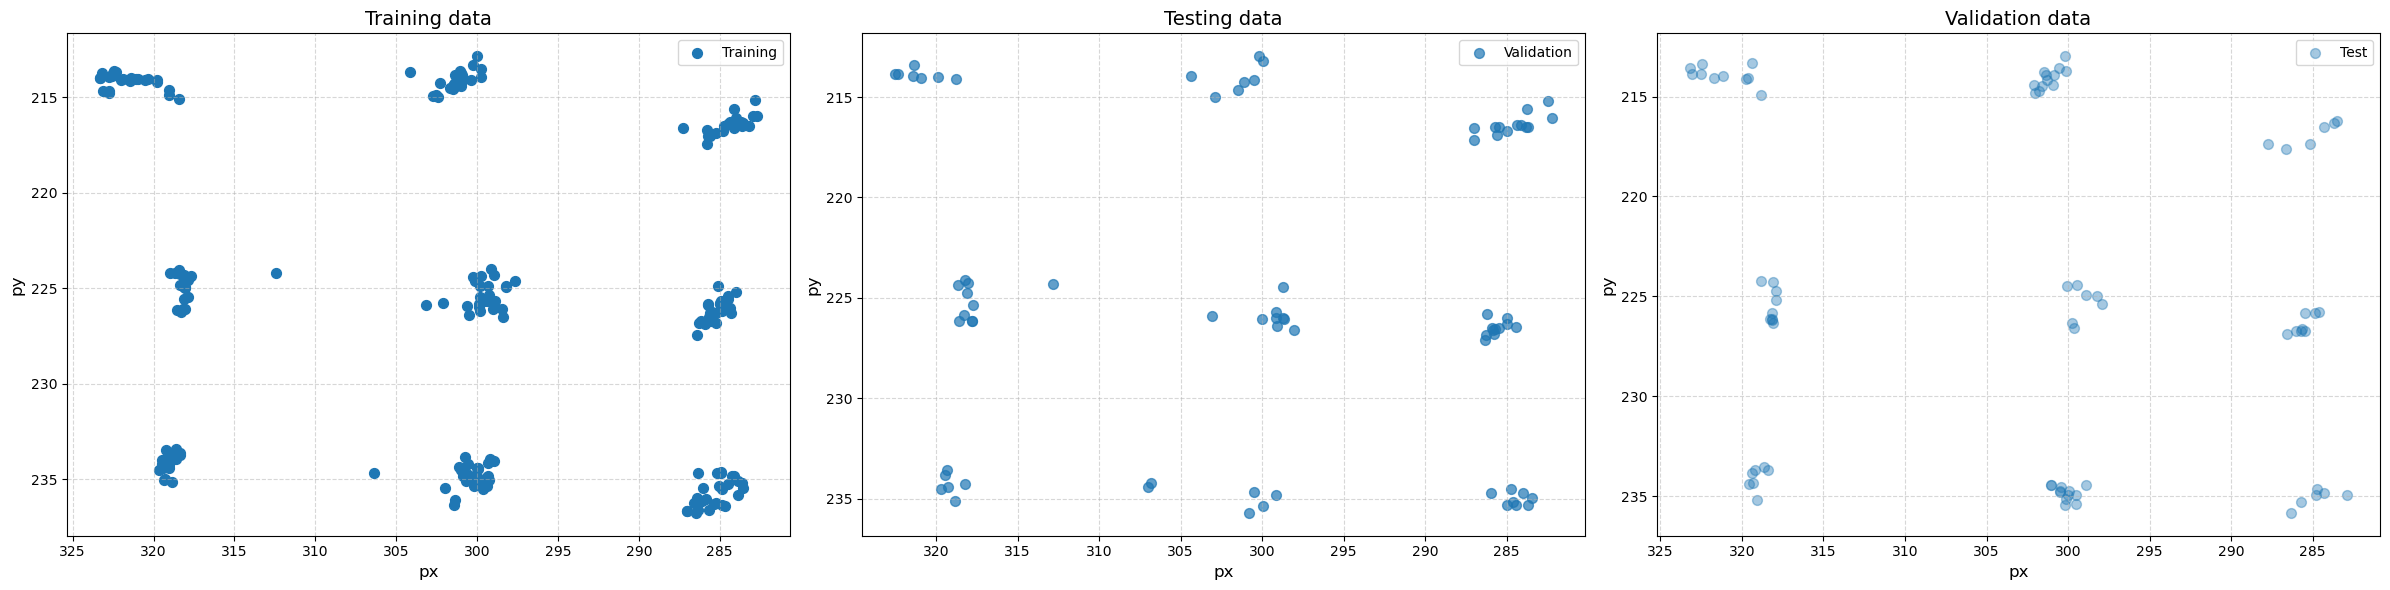

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(input, labels, train_size=0.80, test_size=0.20)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.75, test_size=0.25)


nn_util.plot_data_splits(X_train, X_val, X_test) # uncomment once the splits are made


---
**Task 3 (easy): Reflection on data split💡**
1. Reflect on the benefits of making these splits and identify potential pitfals.


---

In [0]:
#Write your reflection here...
"""
We want different validation data to test the final result of our model on that is different from our training and testing data to make sure
our model actually behaves well and isn't just fitted to the training and test data. (generalzation)
Potential pitfalls could be to use input on both of the calls which means there is cross contaimination between the test set and validation set
which is bad as we want the validation set to be never before seen data in the training process.
"""

## Linear Model
In Assignment 1 Gaze Estimation
 Linear Least Square was used to find model parameters for a gaze estimation model.

---
**Task 4 (easy): Linear Least Square👩‍💻**
1. Run the cell below to learn the model parameters using Linear Least Squares on the entire gaze data training set and visualize the result.


---

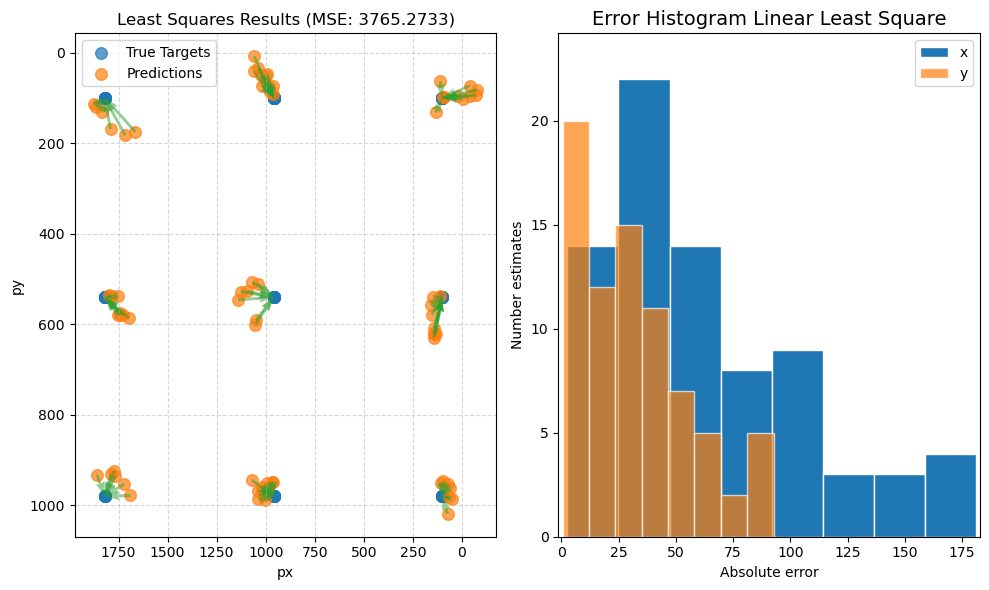

In [23]:
pred_l = nn_util.least_square(X_train, Y_train, X_test)

nn_util.plot_least_square_results(pred_l, Y_test)

The cell below contains the definition of an affine model in Pytorch.

---
**Task 5 (easy): Train a linear model (gaze data)👩‍💻**
1. On a piece of paper draw the architecture of the network given the class definition `LinearModel`
.
**Note:** The class `MSELoss`
 explicitly defines the _Mean Squared Error_ loss function, for pedagogical reasons. Note, the Pytorch library has its own mse loss
.


2. Run the cell below to train the network.


---


<img src="./img/arch_1.jpg" alt="drawing" width="250"/>

Average MSE: 130497.515625


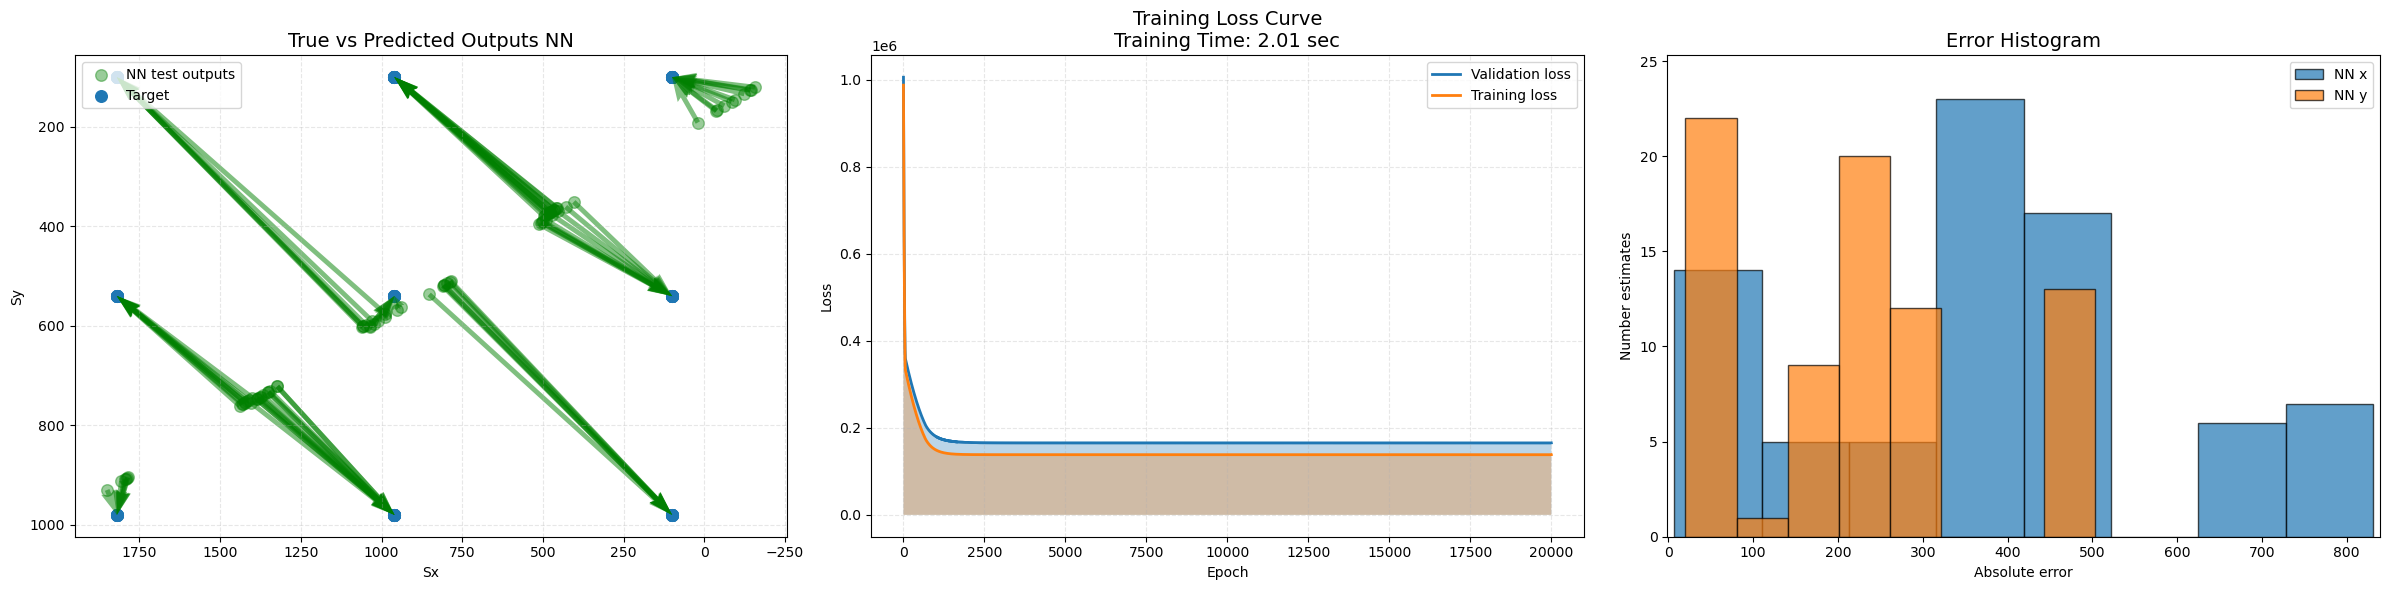

In [24]:
class LinearModel(nn.Module):
    """
    Args:
        input_dim (int): Number of input features.
        output_dim (int): Number of output features.

    Methods:
        forward(x): Passes the input through the linear layer.
    """
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
 
    def forward(self, x):
        """Args:
        x (Tensor): Input tensor.
        Returns:
            Tensor: Output tensor after applying the linear transformation.
        """
        x = self.linear1(x)
        return x
    
class MSELoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(MSELoss, self).__init__()
        self.reduction = reduction

    def forward(self, input, target):
        squared_diff = (input - target) ** 2
        if self.reduction == 'mean':
            return squared_diff.mean()
        elif self.reduction == 'sum':
            return squared_diff.sum()
        else:
            raise ValueError("Invalid reduction type. Use 'mean' or 'sum'.")

    
def train_model(model, criterion, optimizer, X_train, Y_train, X_val=None, Y_val=None, num_epochs=100):
    """
    Args:
        model (nn.Module): The neural network model to train.
        criterion (nn.Module): The loss function to minimize.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        X_train (Nx2 Tensor): Training input data.
        Y_train (Nx2 Tensor): Training target data.
        X_val (Nx2 Tensor, optional): Validation input data. Defaults to None.
        Y_val (Nx2 Tensor, optional): Validation target data. Defaults to None.
        num_epochs (int): Number of training epochs.

    Returns:
        list: Loss values for each epoch (training).
        list: Loss values for each epoch (validation).
        float: Training time.
    """
    start_time = time.time()
    train_losses = []
    val_losses = []
    model_params = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        train_losses.append(loss.item())


        with torch.no_grad():
            val_outputs = model(X_val)
            model_params.append(model.parameters())
            val_loss = criterion(val_outputs, Y_val)
            val_losses.append(val_loss.item())

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, val_losses, training_time



def test_model(model, X_test, Y_test):
    """
    Evaluates a trained model on test data.

    Args:
        model (nn.Module): The trained neural network model.
        X_test (Tensor): Test input data.
        Y_test (Tensor): Test target data.

    Returns:
        float: Mean squared error (MSE) over the test set.
        np.ndarray: Predicted values as a numpy array.
        np.ndarray: True values as a numpy array.
        np.ndarray: Absolute errors for x and y coordinates.
    """
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        mse = mean_squared_error(Y_test.cpu().numpy(), test_output.cpu().numpy())
        predictions = test_output.cpu().numpy()
        true_values = Y_test.cpu().numpy()
        errors = np.abs(true_values - predictions)

    return mse, predictions, true_values, errors



# Set parameters
input_dim = 2
output_dim = 2
learning_rate = 0.1
epoch = 20000

# Generate training data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)  
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)   

model = LinearModel(input_dim, output_dim)
criterion = MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
losses, val_losses, training_time = train_model(model, criterion, optimizer, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, num_epochs=epoch)

# Test the model
mse, Y_pred_lm, true_values, errors_nn = test_model(model, X_test_tensor, Y_test_tensor)
print(f'Average MSE: {mse}')

# Visualize results
nn_util.plot_results(
        Y_test_tensor,
        Y_pred_lm,
        errors_nn,
        losses,
        val_losses,
        model_name='NN',
        training_time=training_time
    )

You will notice, that the neural network has a difficulty in predicting gaze compared to the linear least square optimization. 

---
**Task 6 (easy): Analyse results💡**
1. Provide at least 3 reasons to why the neural network performs worse compared to the linear least squares. 


---

In [0]:
# Write your reflections here...
"""
1. Since the model is basically just badly estimating linear least squares as it is just a 2 input 2 output NN it makes sense that the real math version
performs better than trying to badly estimate with a NN.
2. We might be hitting a local minima instead of the global minima which wouldn't matter in the linear least squares as that is just not a thing
3. We might not have enough data which would make the NN less generalizable and good. LSTSQ sidesteps thi
"""

## Improving performance
The following steps will investigate reasons for the poorer performance and include:
- Data scale
- The learning rate
- The number of iterations

### Data wrangling
The following step investigate the impact of preprocessing of the data by normalizing the input and label data. It also investigates the impact of the learning rate and the number of iterations through `grid search`
.

**Data structure for plotting**
To investigate the performance of the models the function `plot_results_collected`
 from the file `nn_util.py`
 is used. This function takes six dictionaries with models version as key containing the following for each model trained:
- Model instance (object)
- List of training losses (float)
- List of validation losses (float)
- Training time (float)
- $N \times 2$ array of predictions on test data (float)
- List of prediction errors (float)

The data needed to populate these data structures is provided gradually througout the exercise. It is important to name the models based on the data and hyper parameters used.


---
**Task 7 (easy): Train a linear model (normalized gaze data and synthetid gaze data)👩‍💻**
1. Complete the `DataScaler`
 class by implementing the `normalize`
 function and the `denormalize`
 function. 


$$
x_{\text{normalized}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

$$
x_{\text{denormalized}} = x_{\text{normalized}} \cdot (x_{\max} - x_{\min}) + x_{\min}
$$
2. Use `DataScaler`
to normalize the data in the `pupil_coordinates.csv`
 and `screen_coordinates.csv`
 files.
3. The nested for-loops performs grid search of hyper parameter settings. In the nested for-loops:    - Train a model on the normalized data using the `train_model`
 function.
    - Test the model using the `test_model`
 function.
    - For each model store results in the designated dictionaries:        - Model instance (`LinearModel`
)
        - Loss (training)
        - Loss (validation)
        - Training time
        - Predictions for test data 
        - Prediction errors 




4. Use the function `plot_results_collected`
 from the `nn_util.py`
 file, to visualize the result.


---

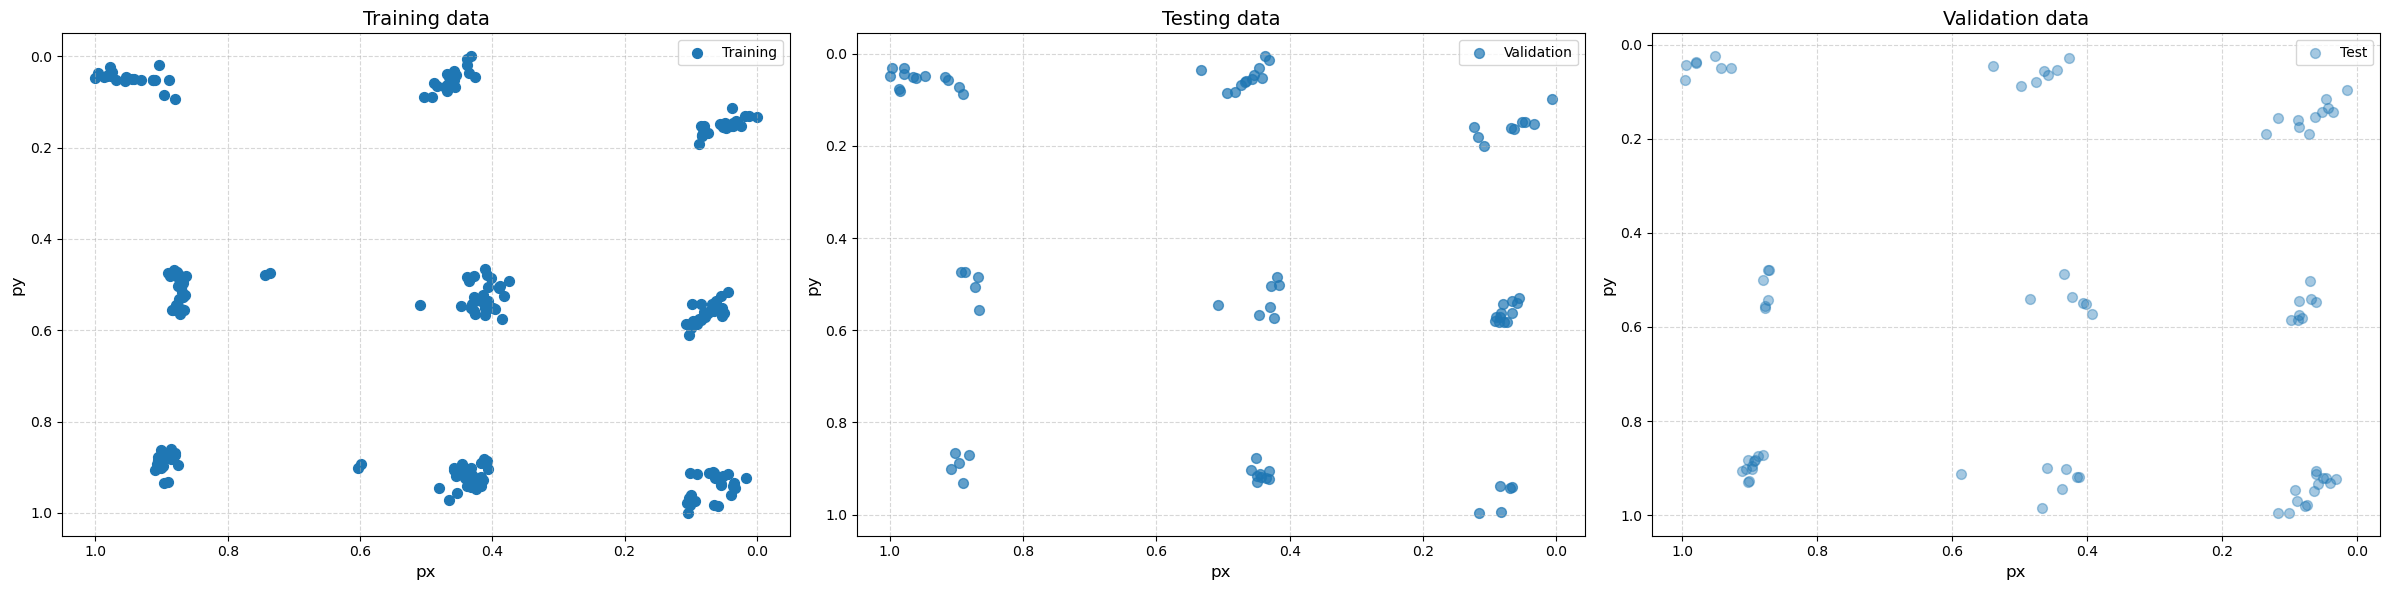

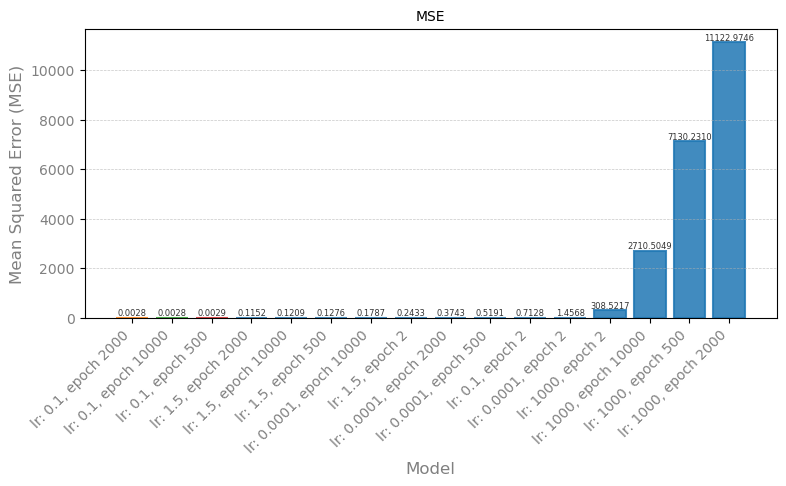

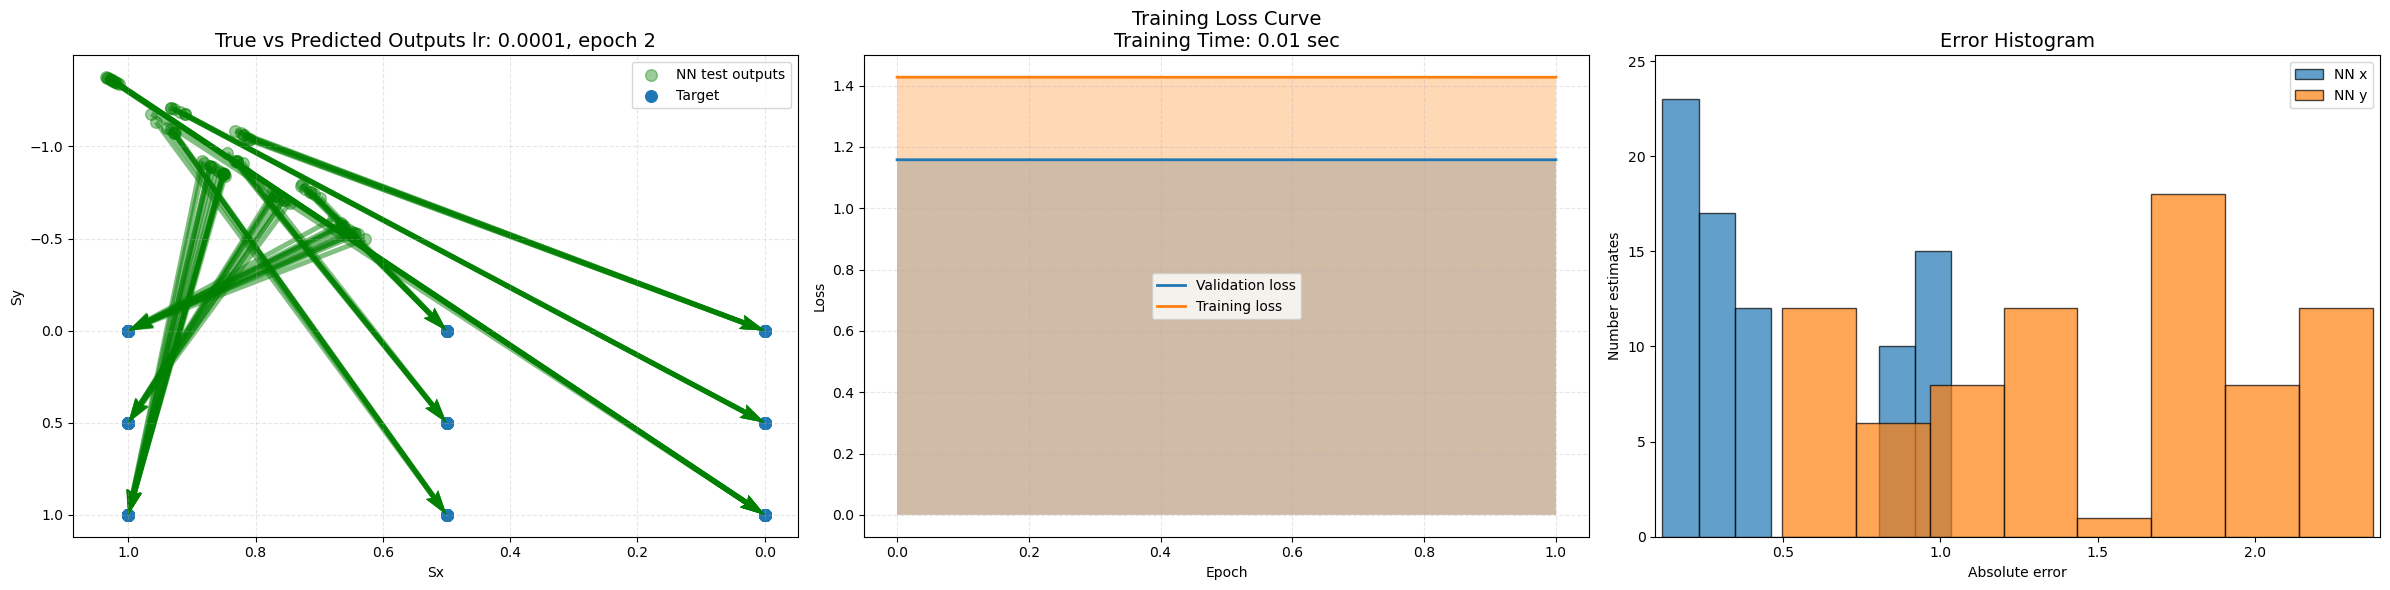

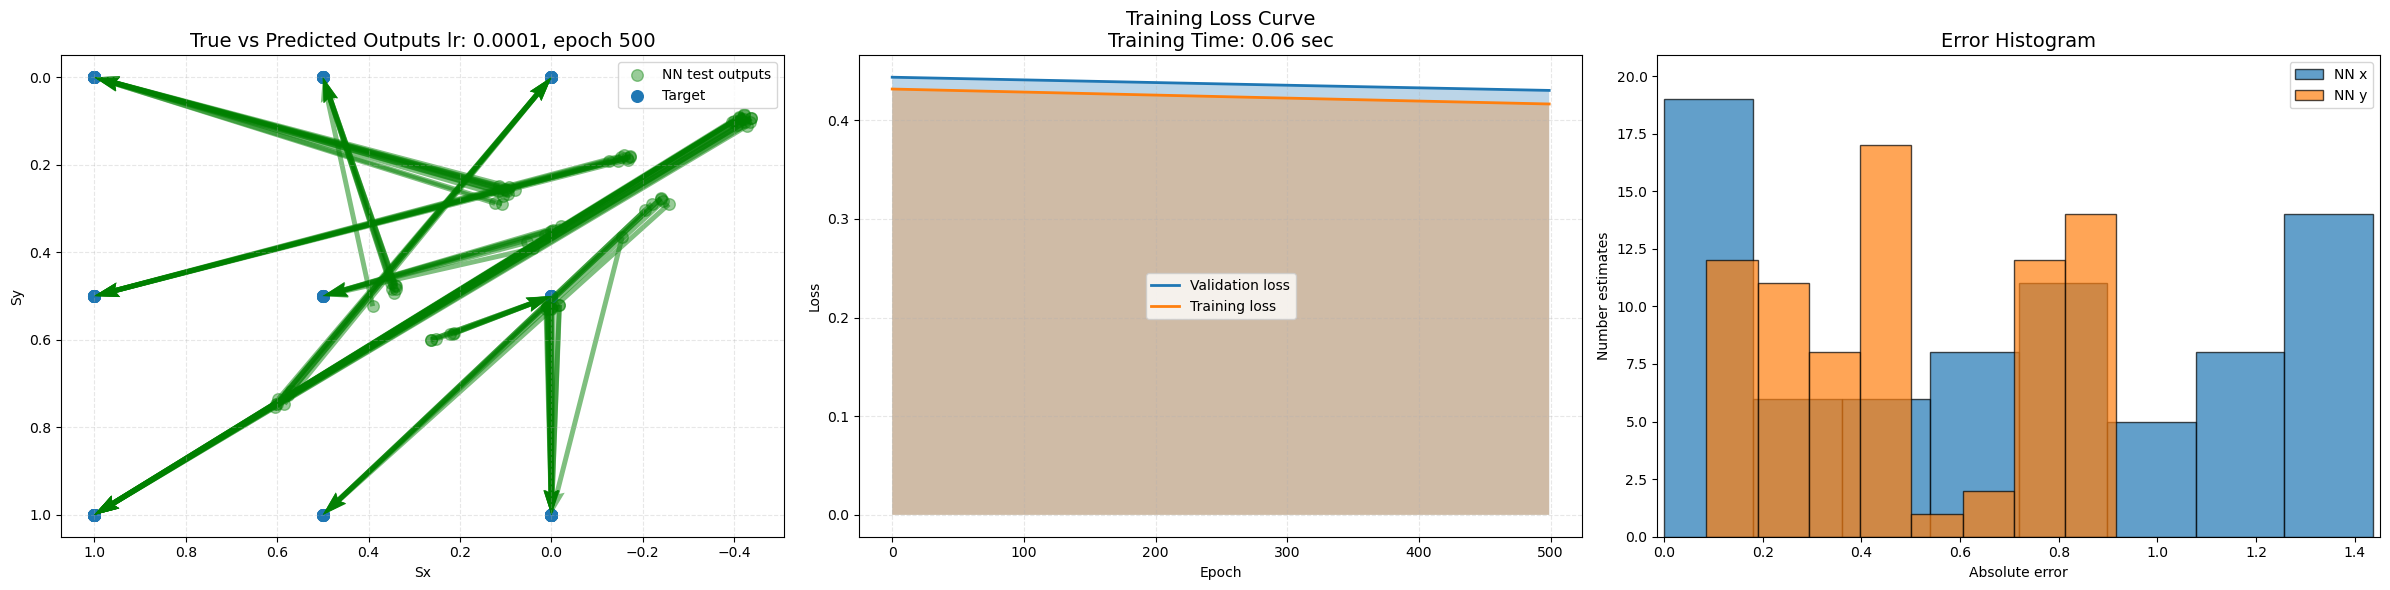

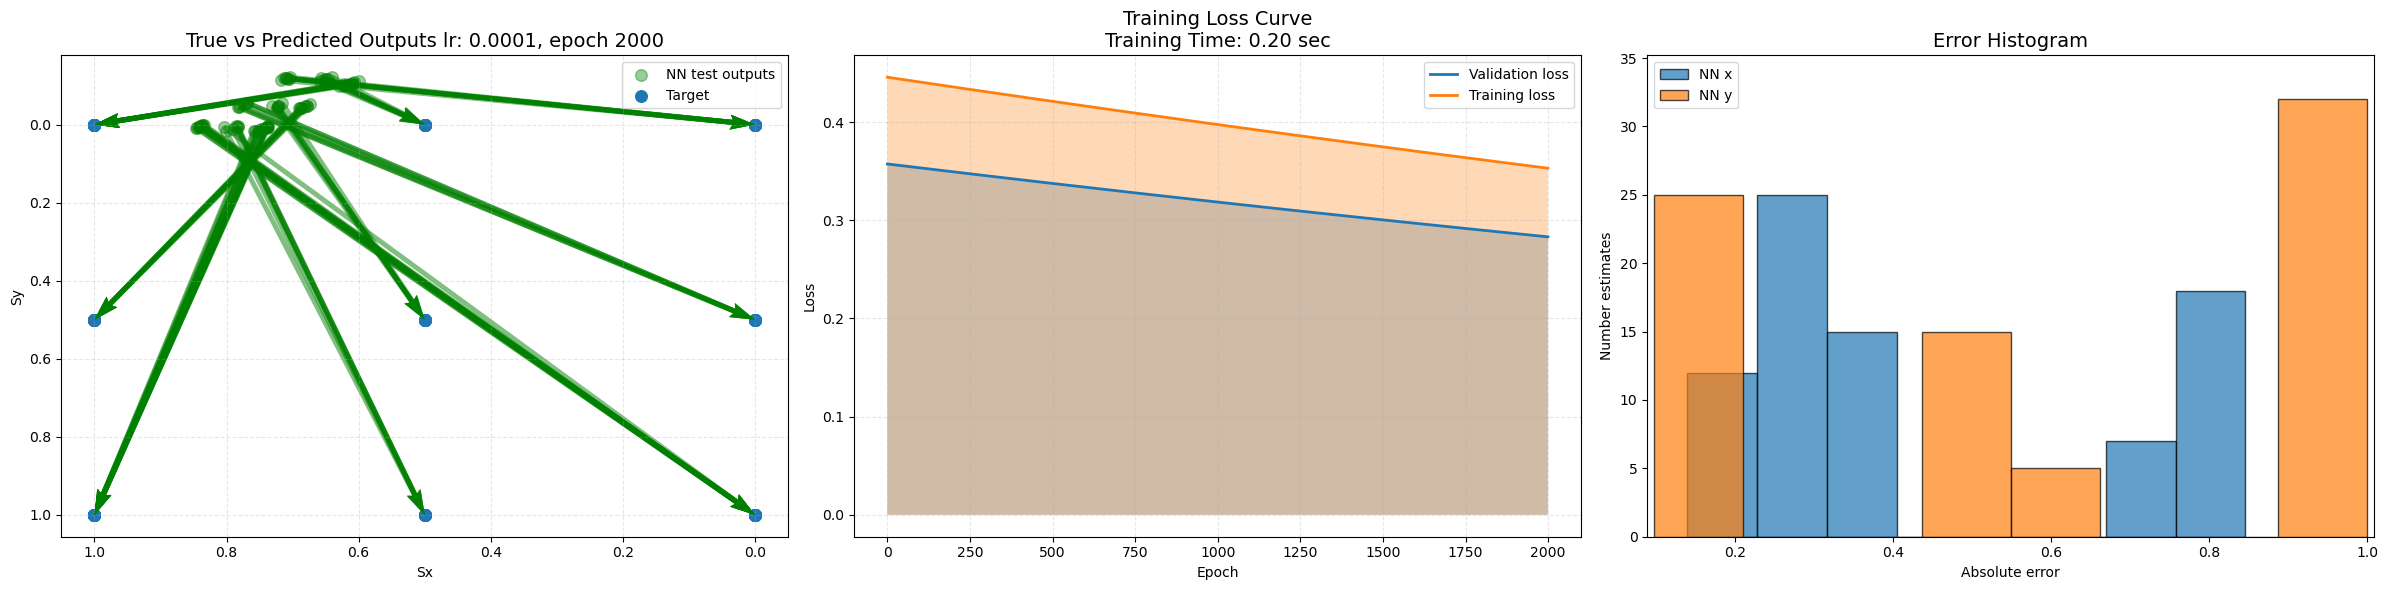

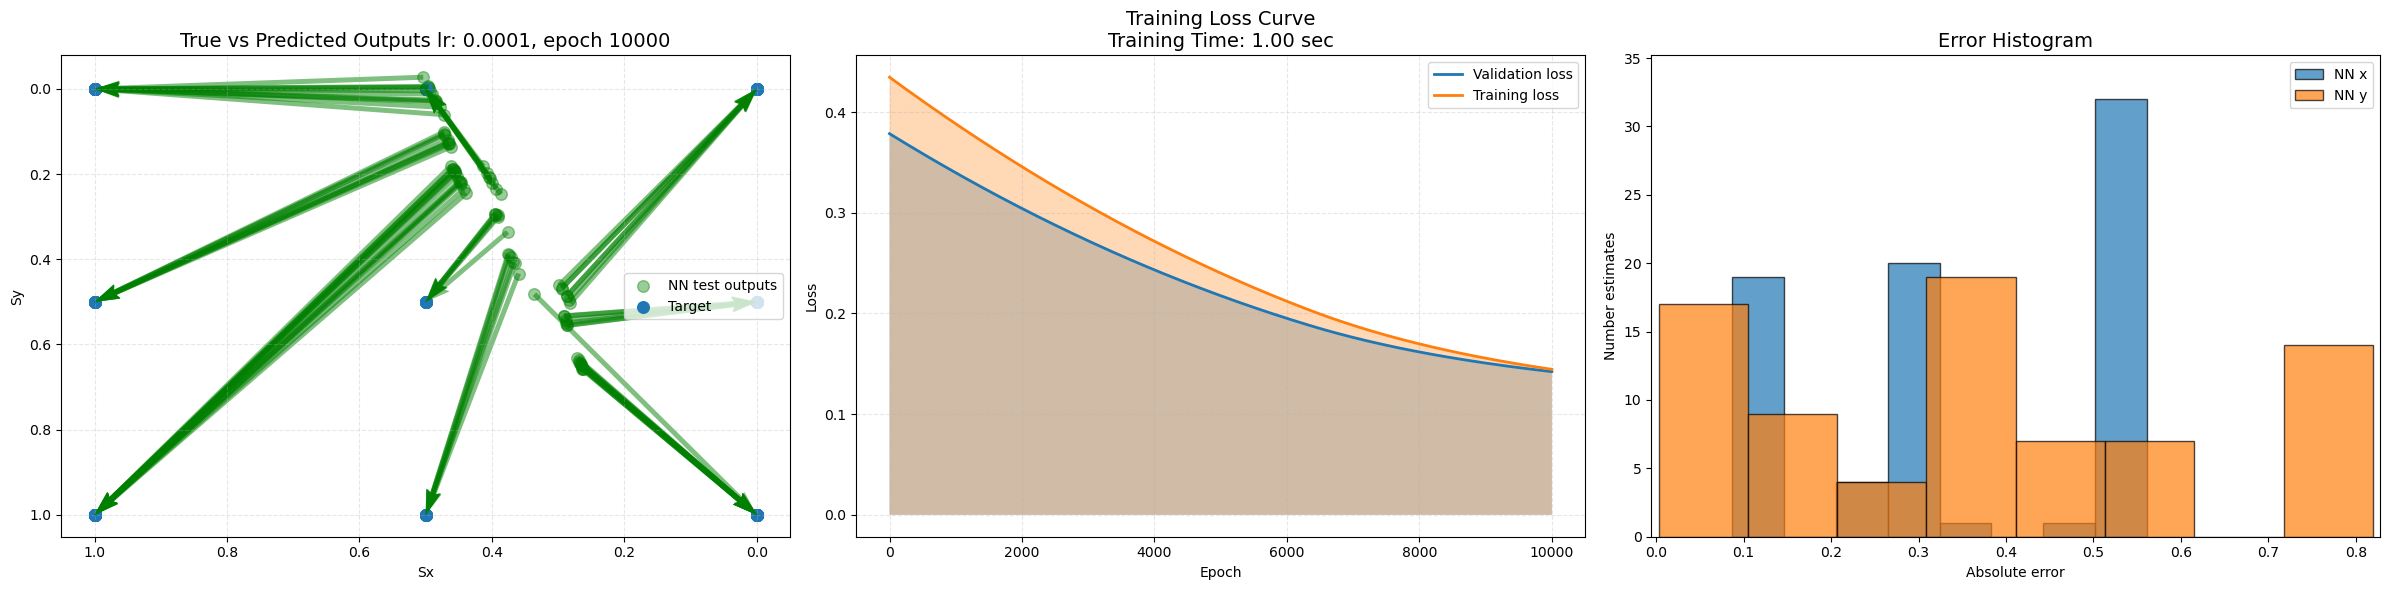

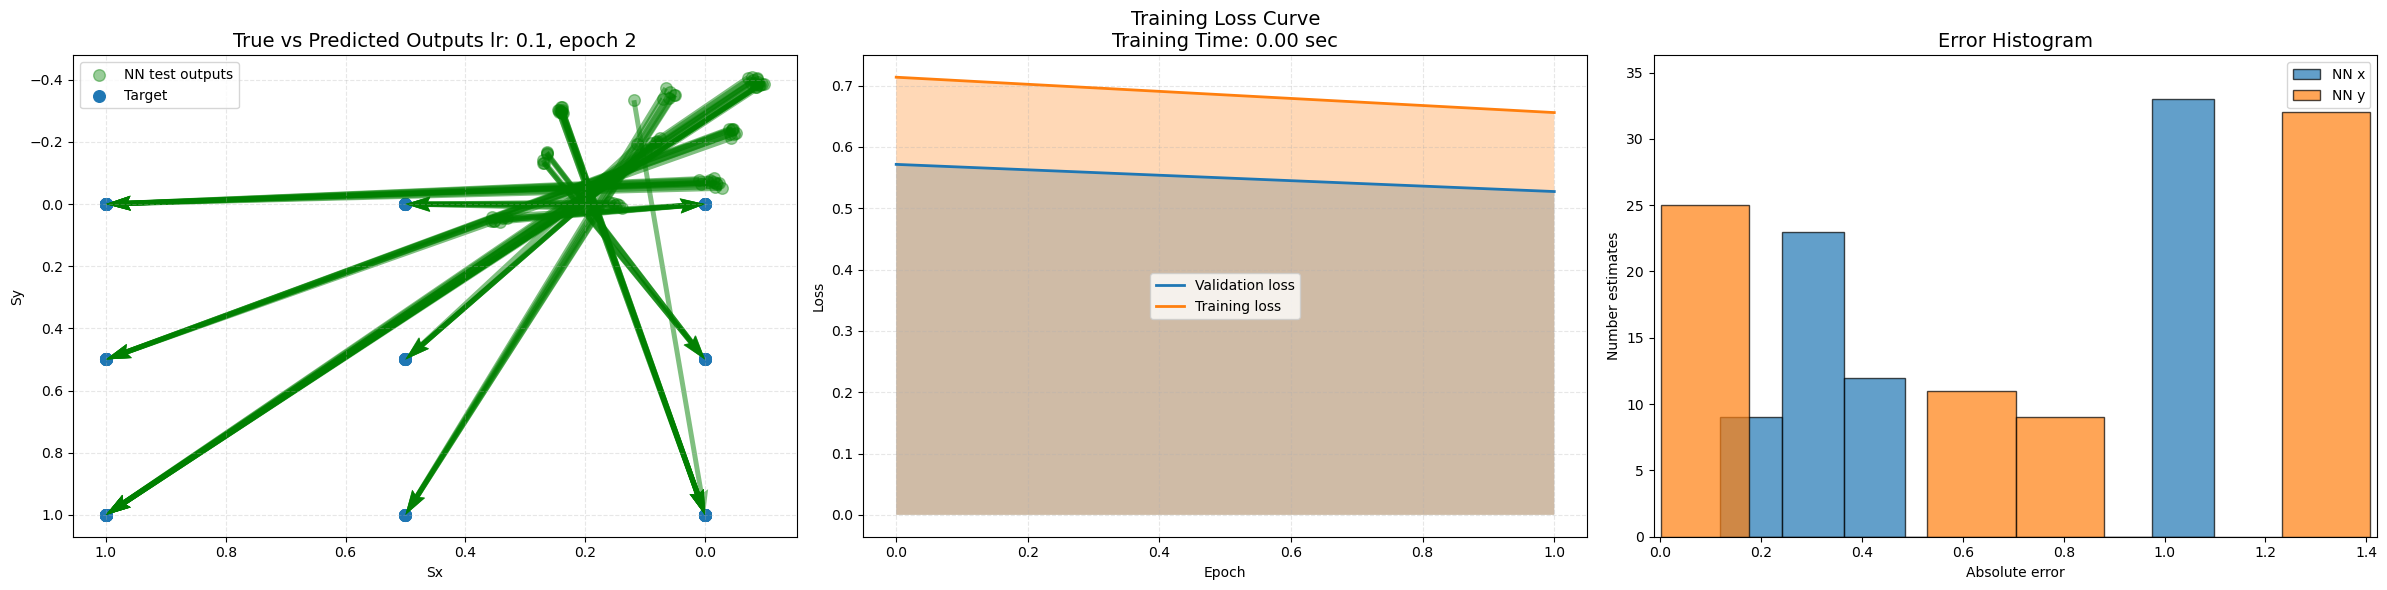

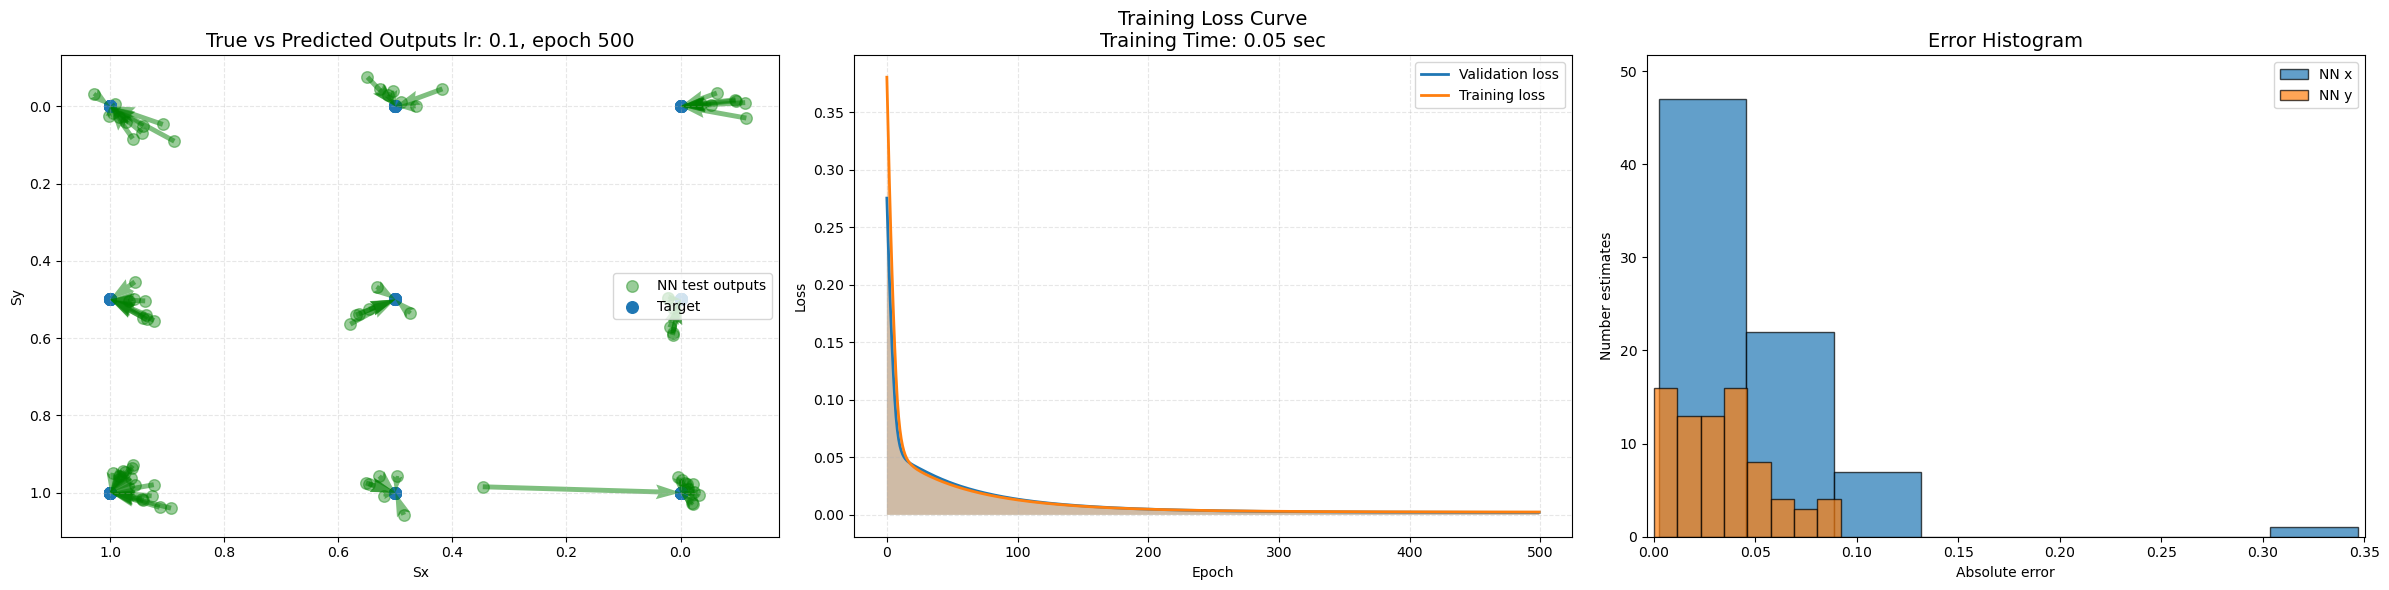

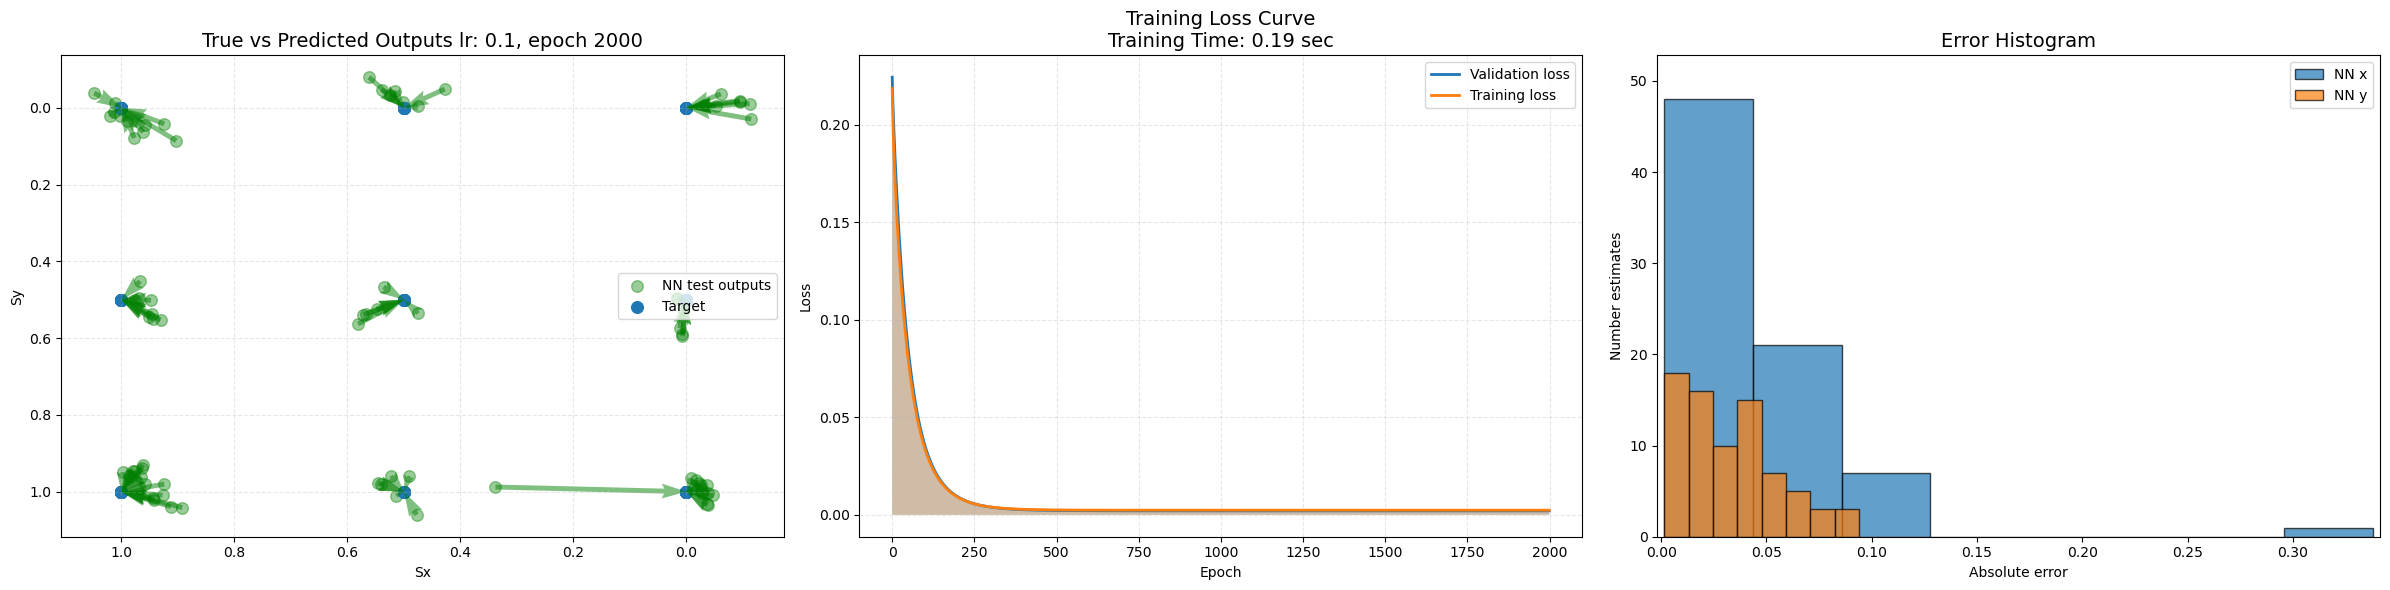

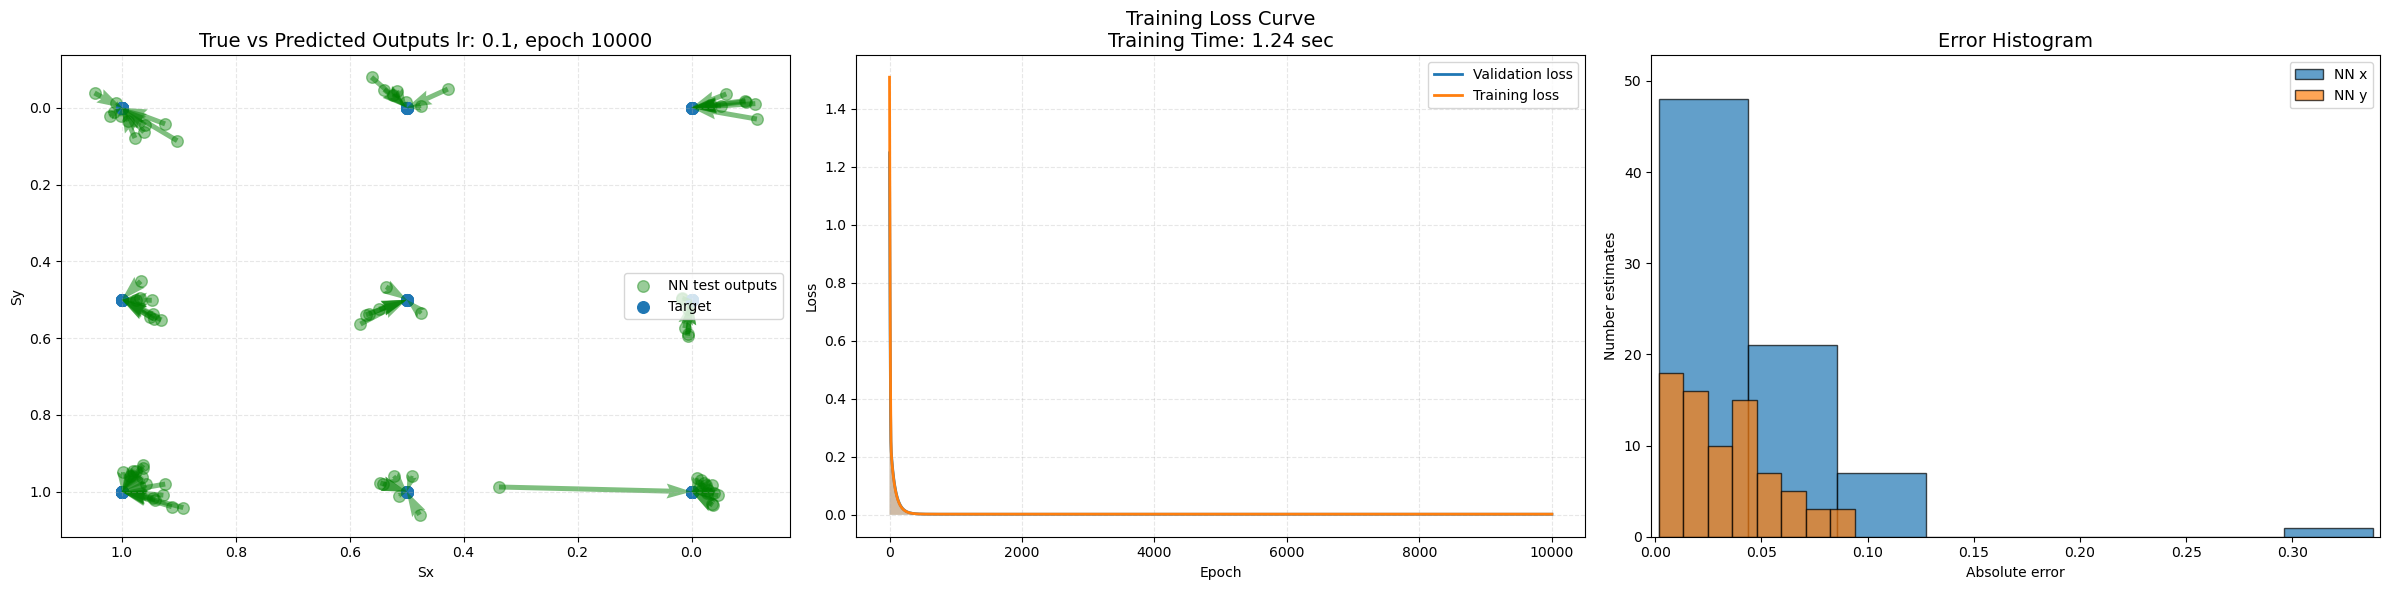

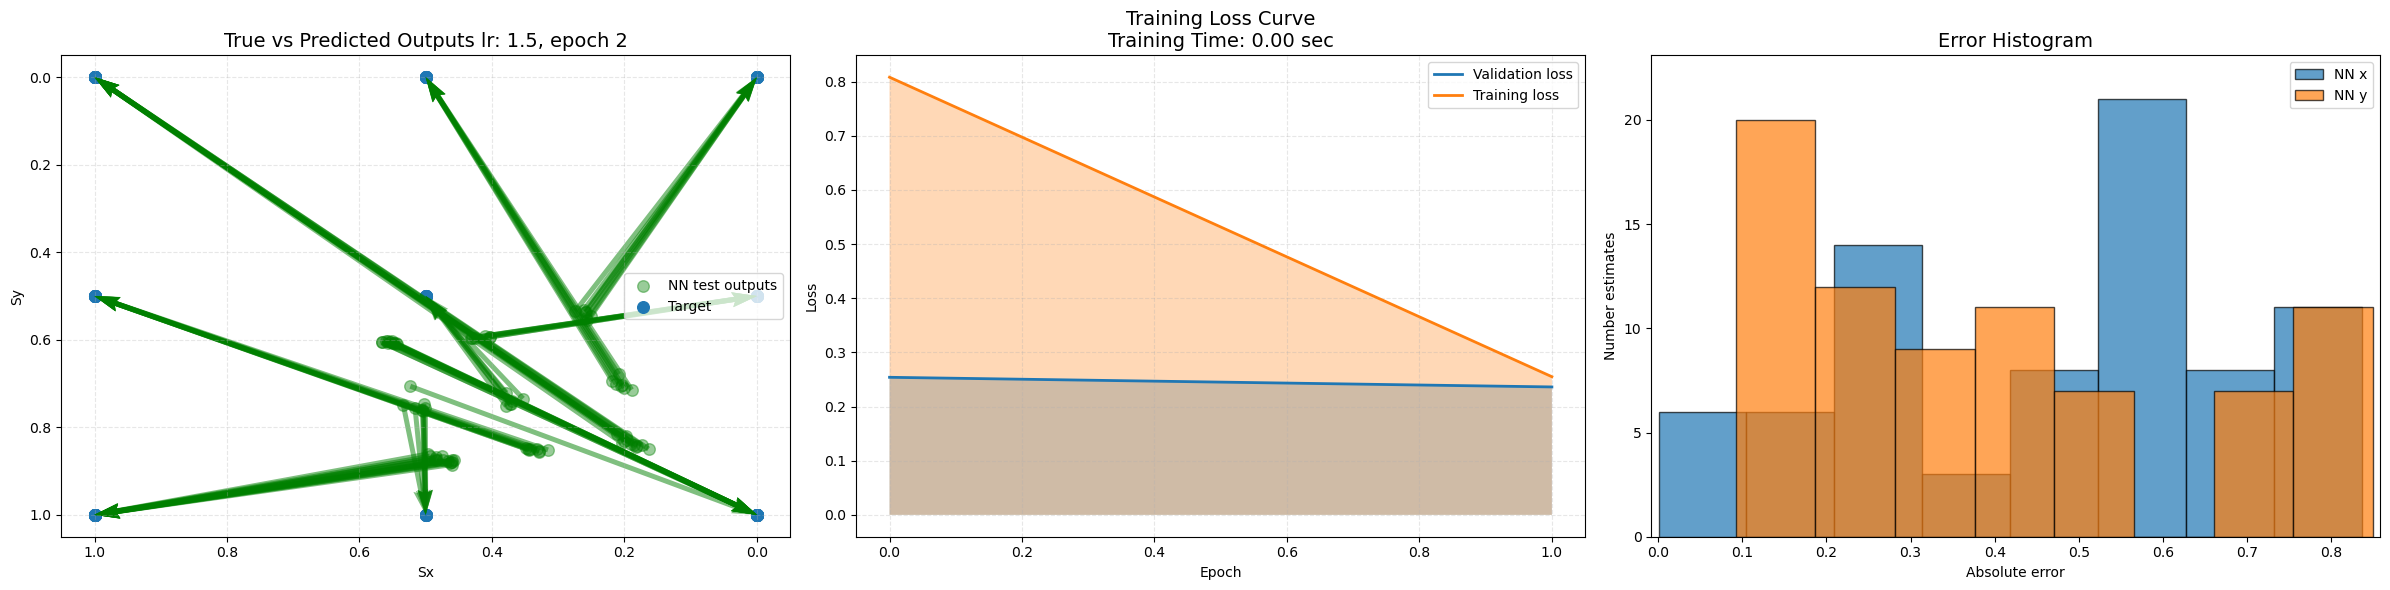

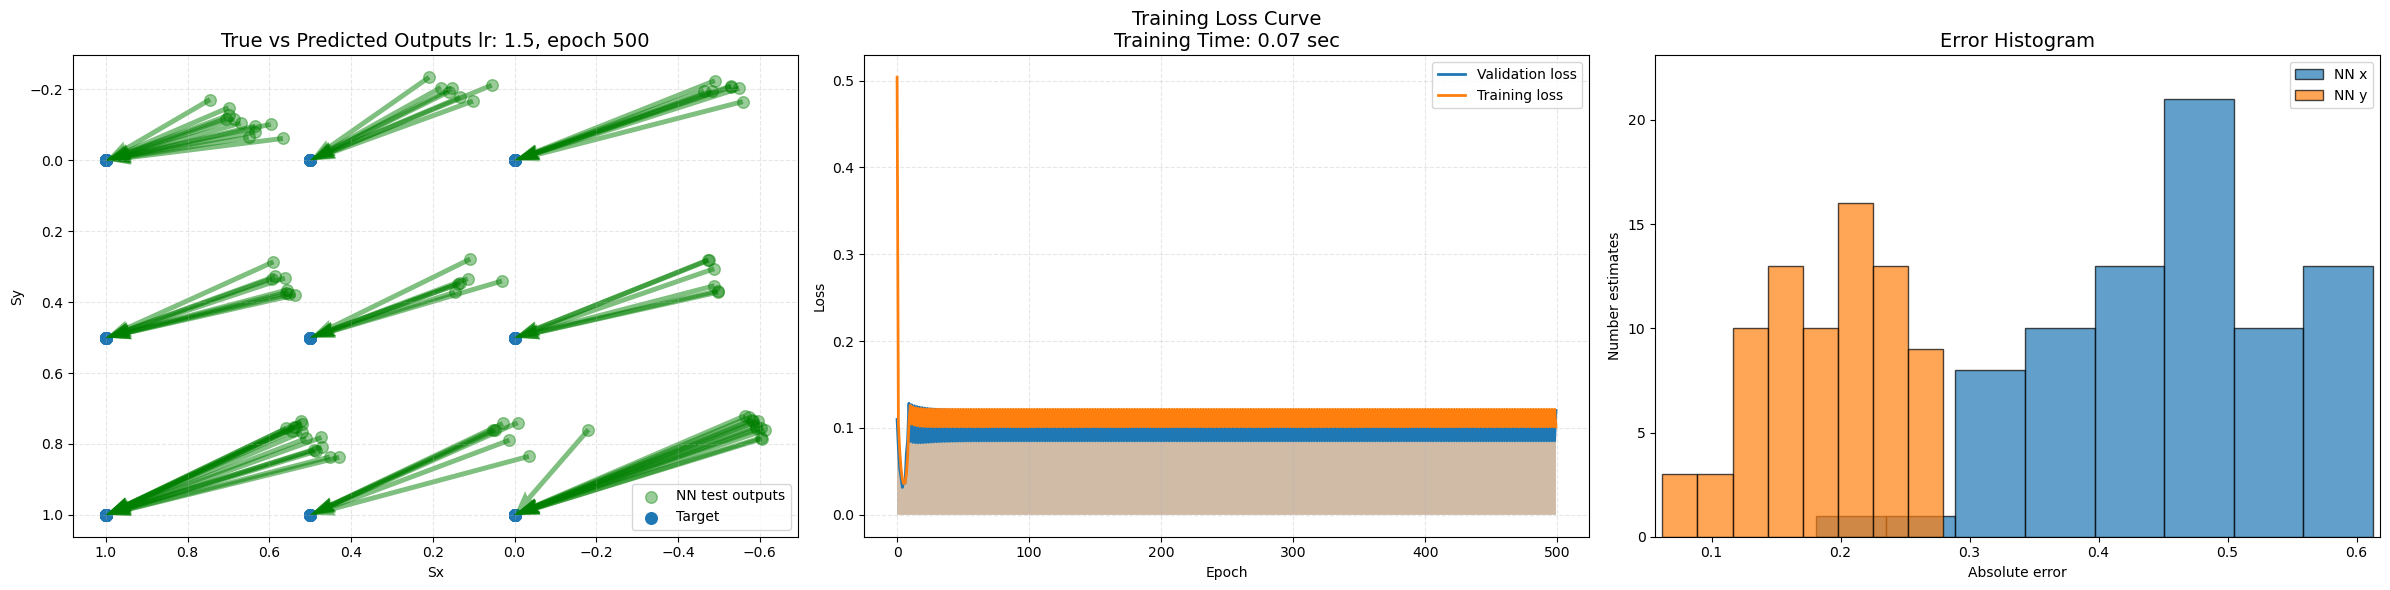

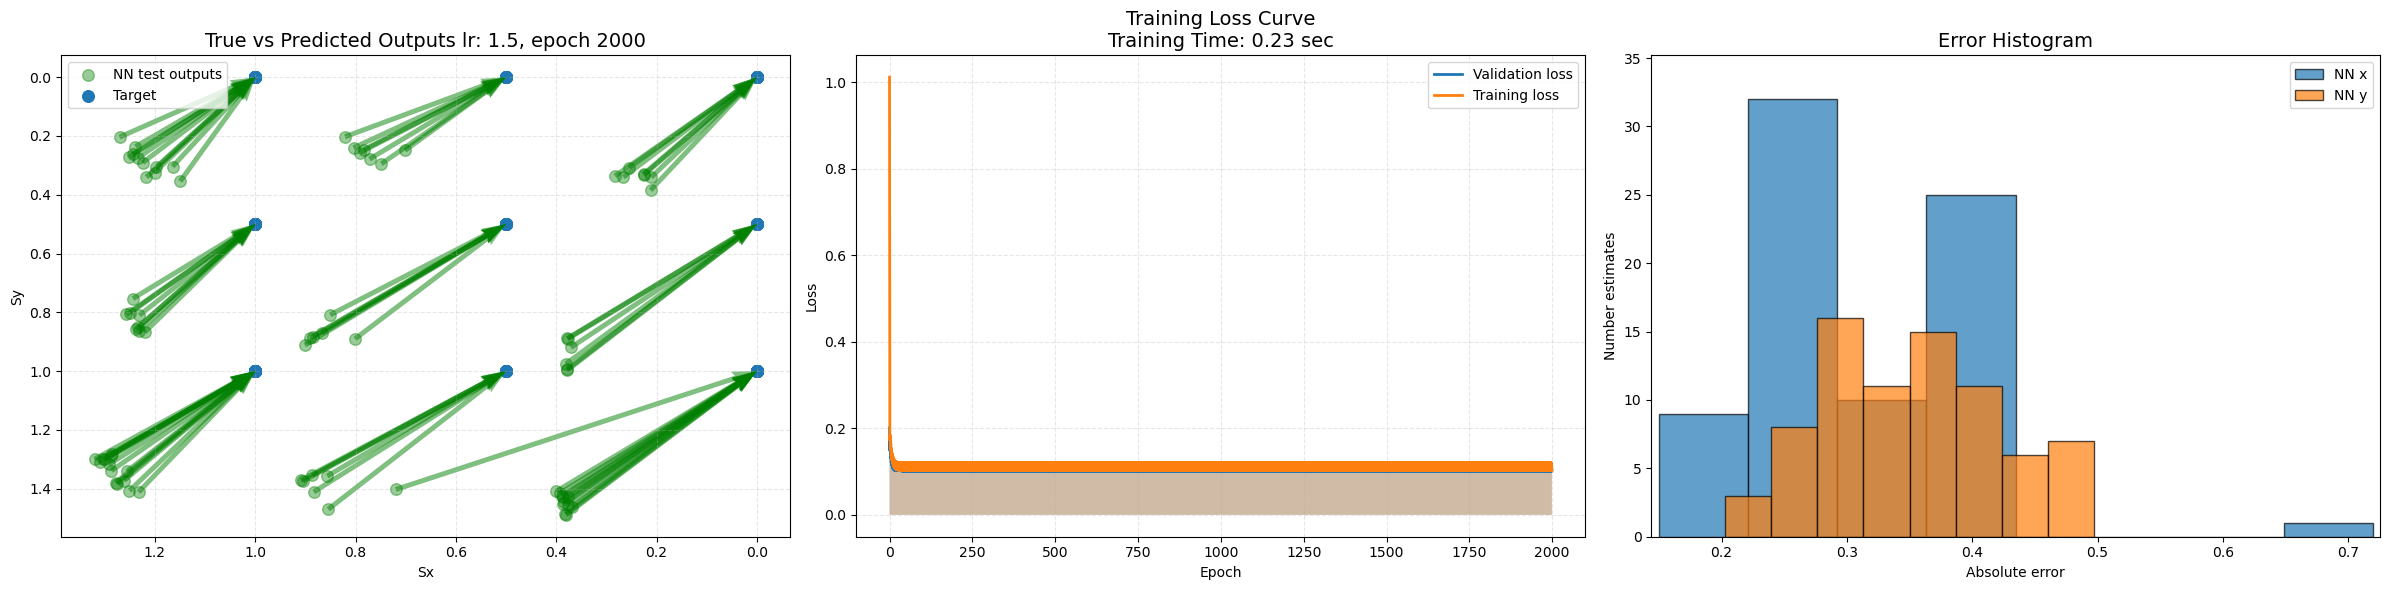

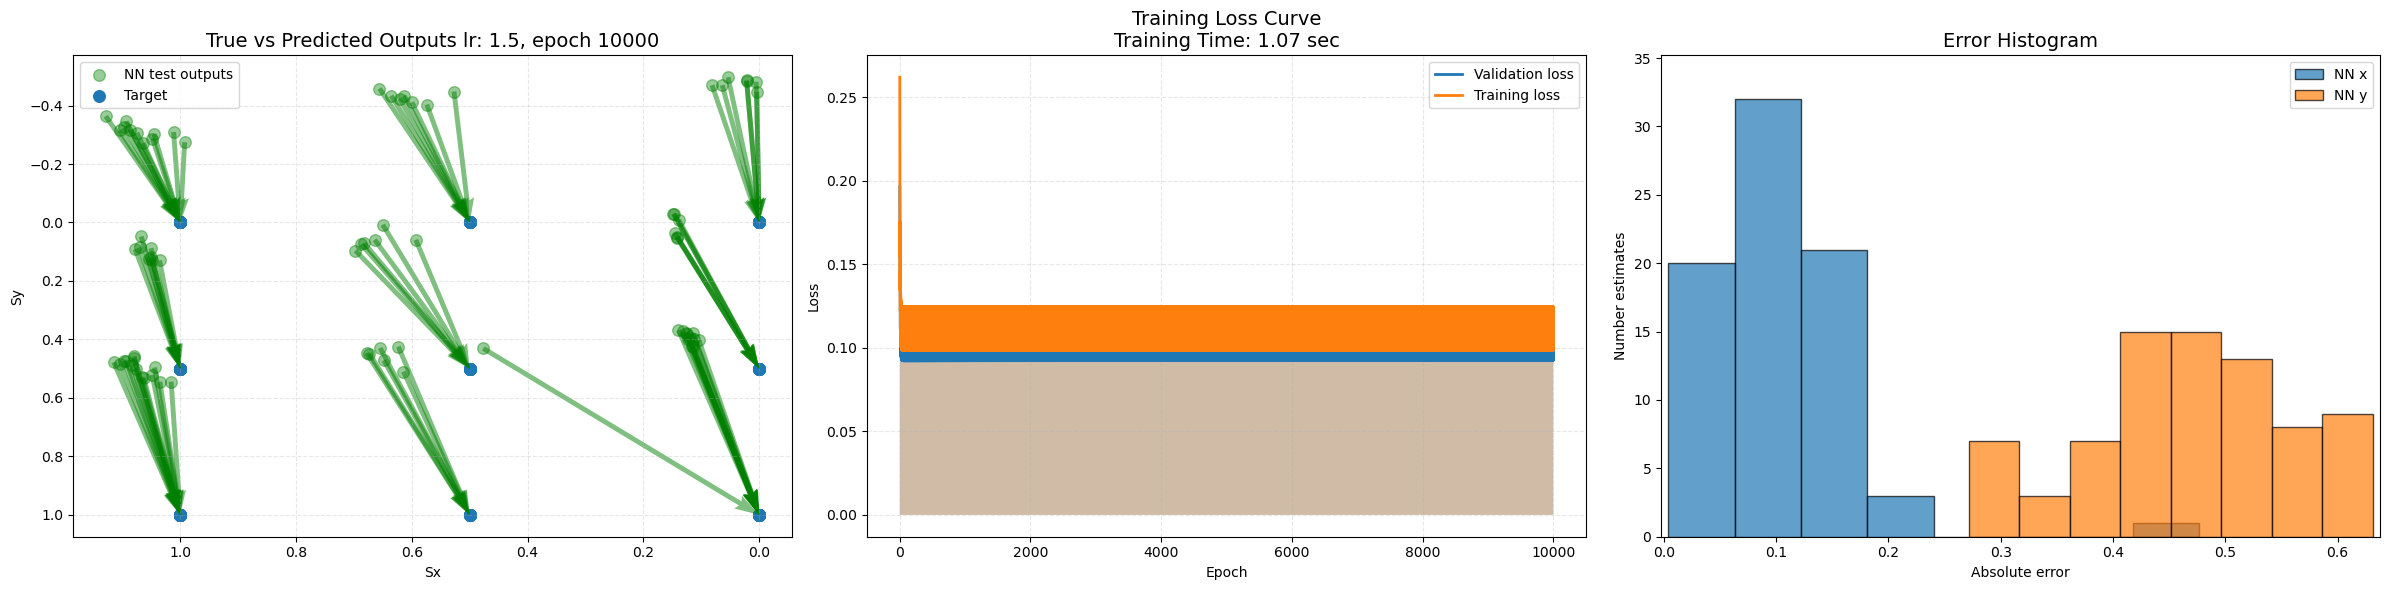

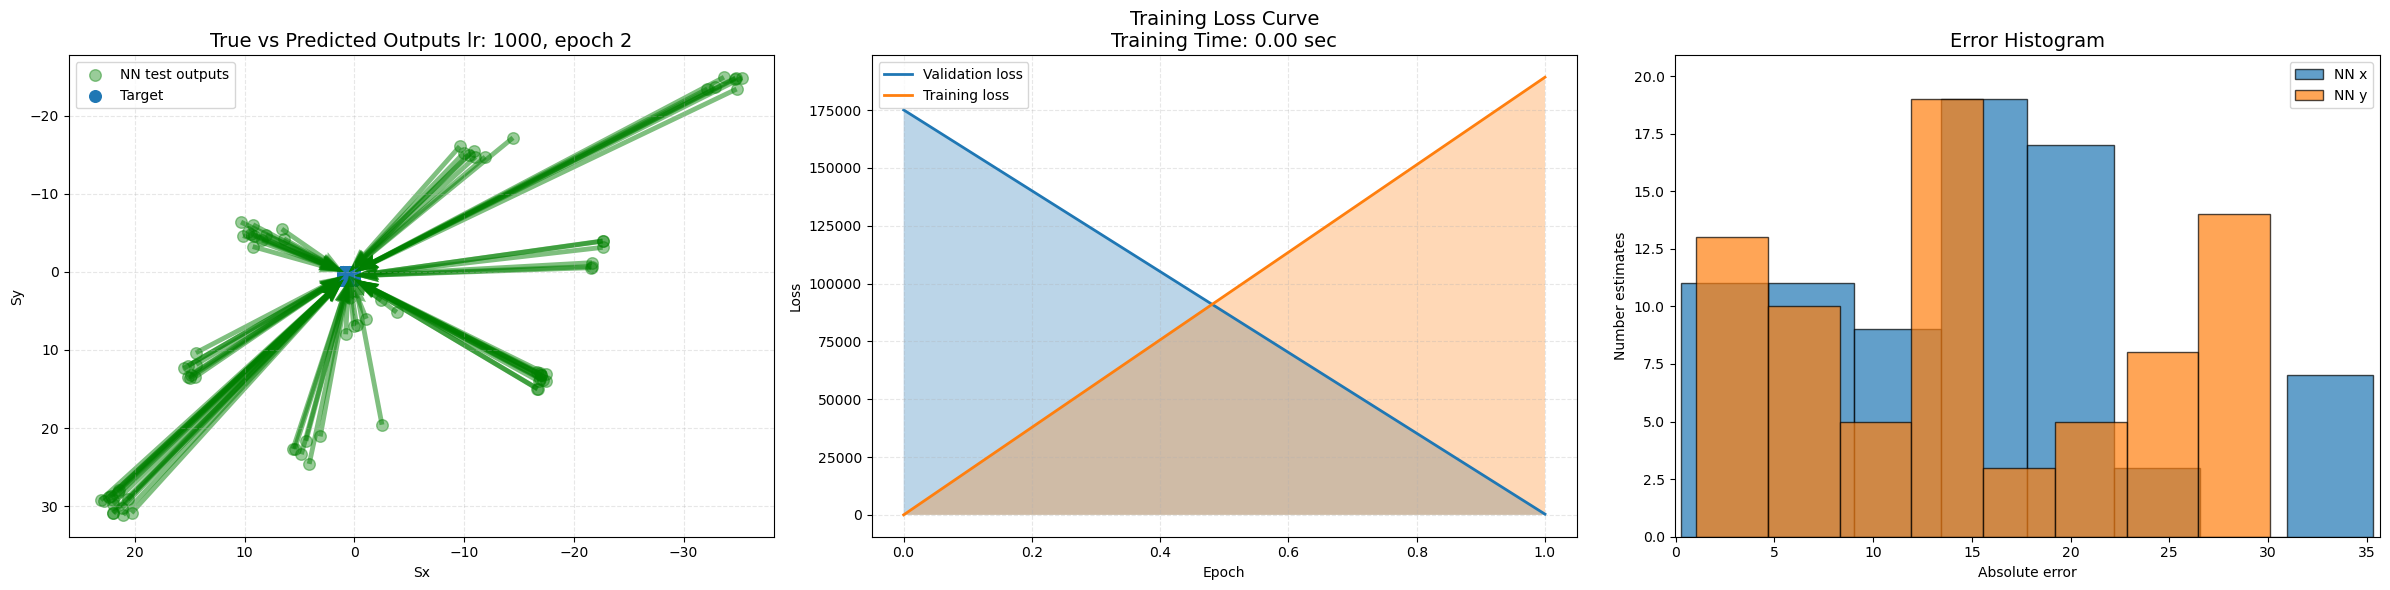

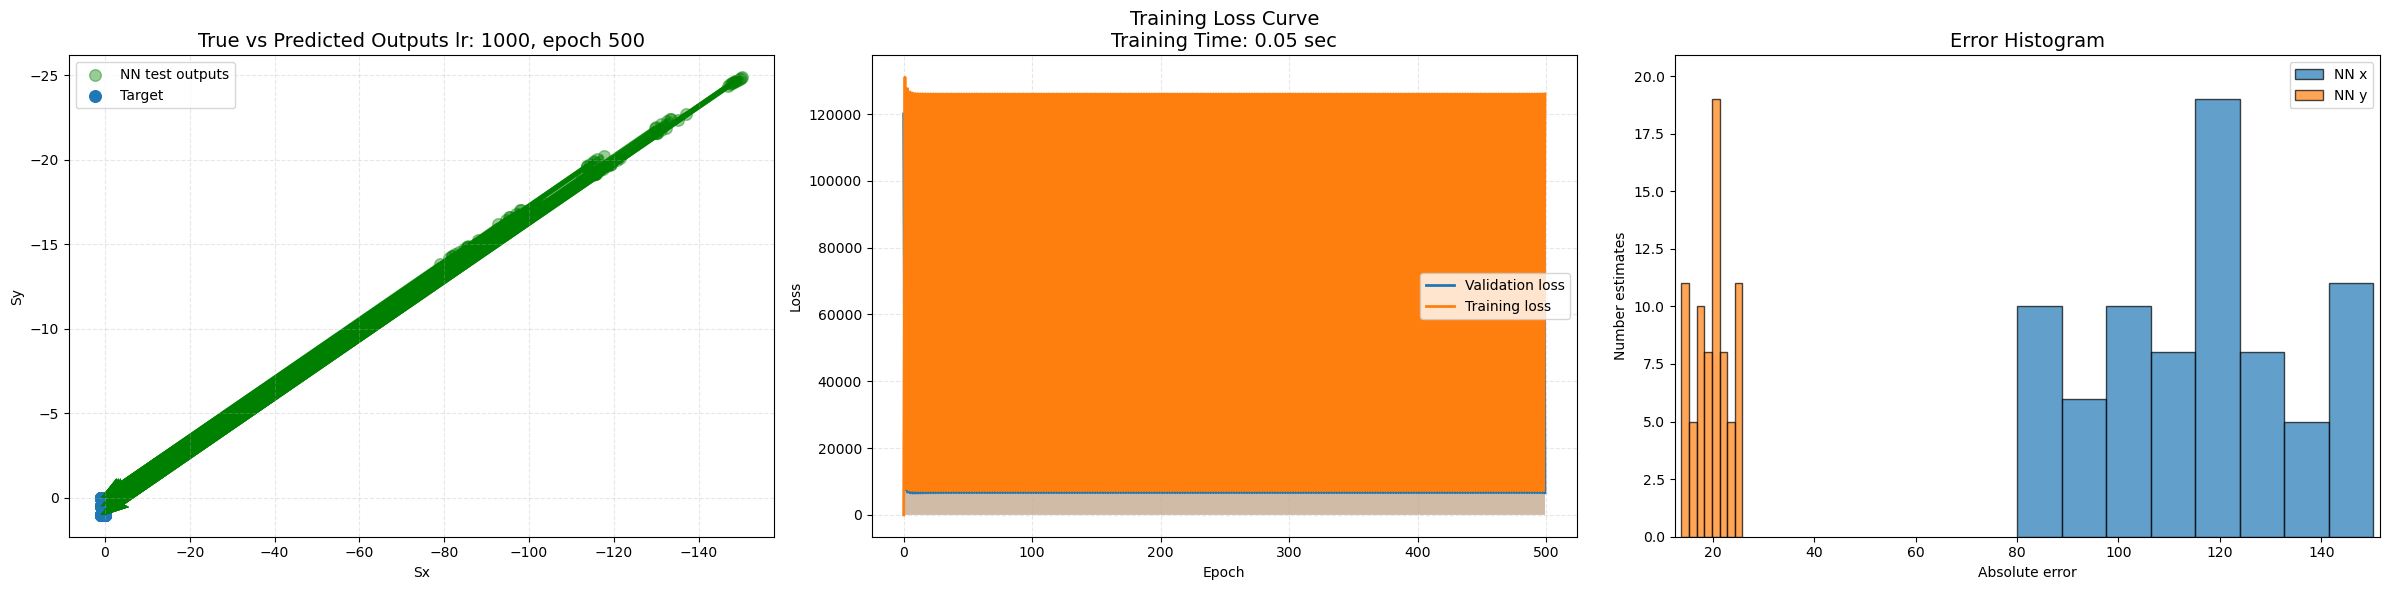

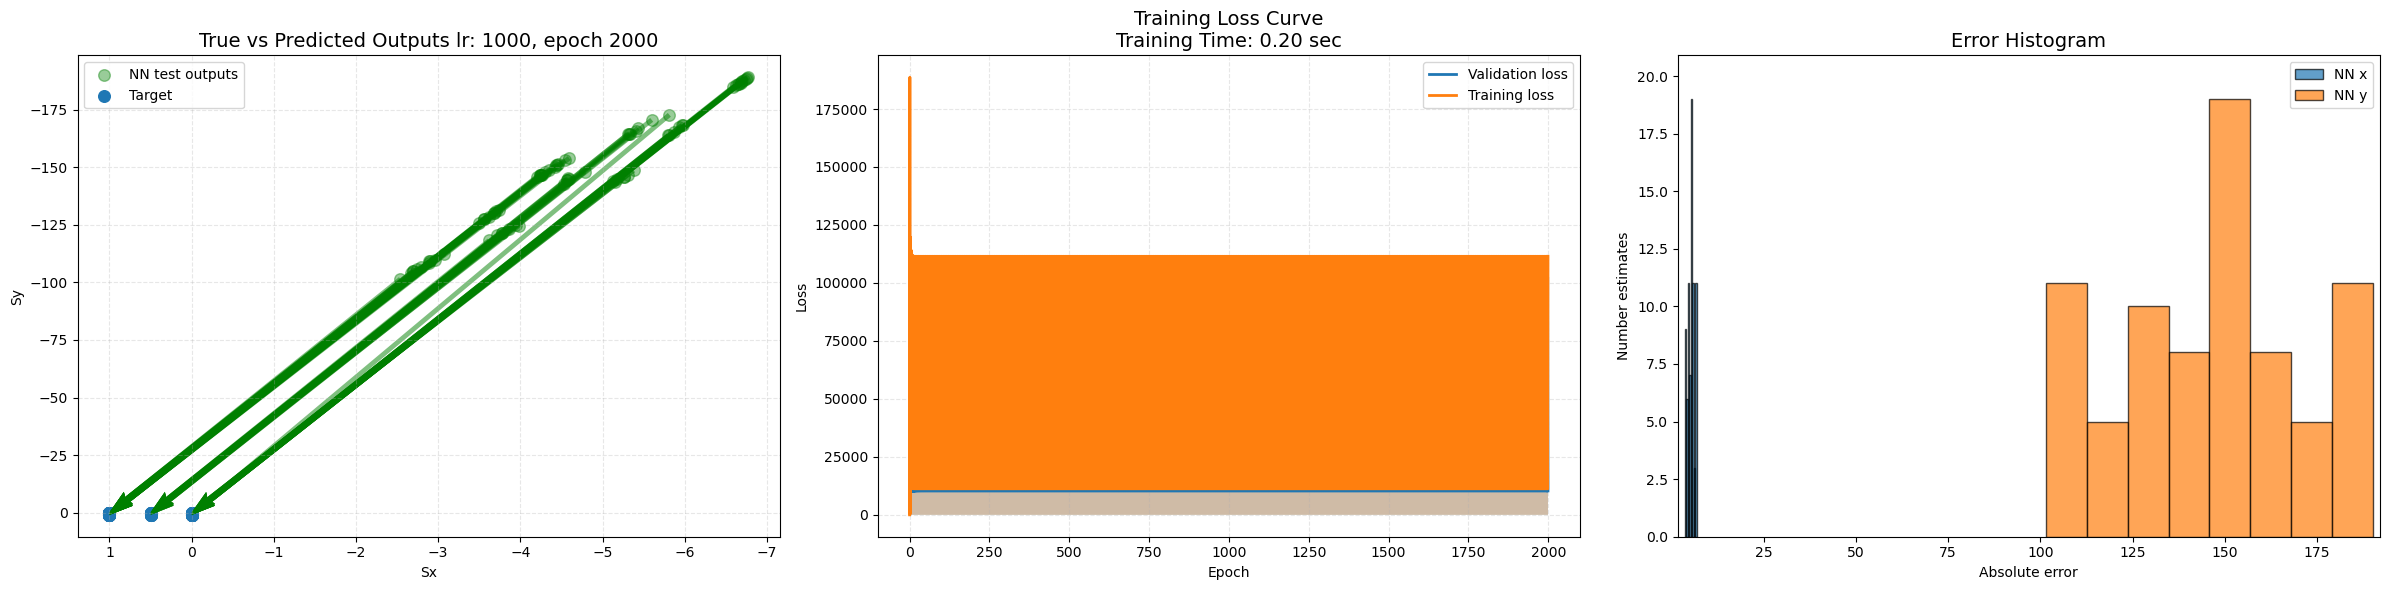

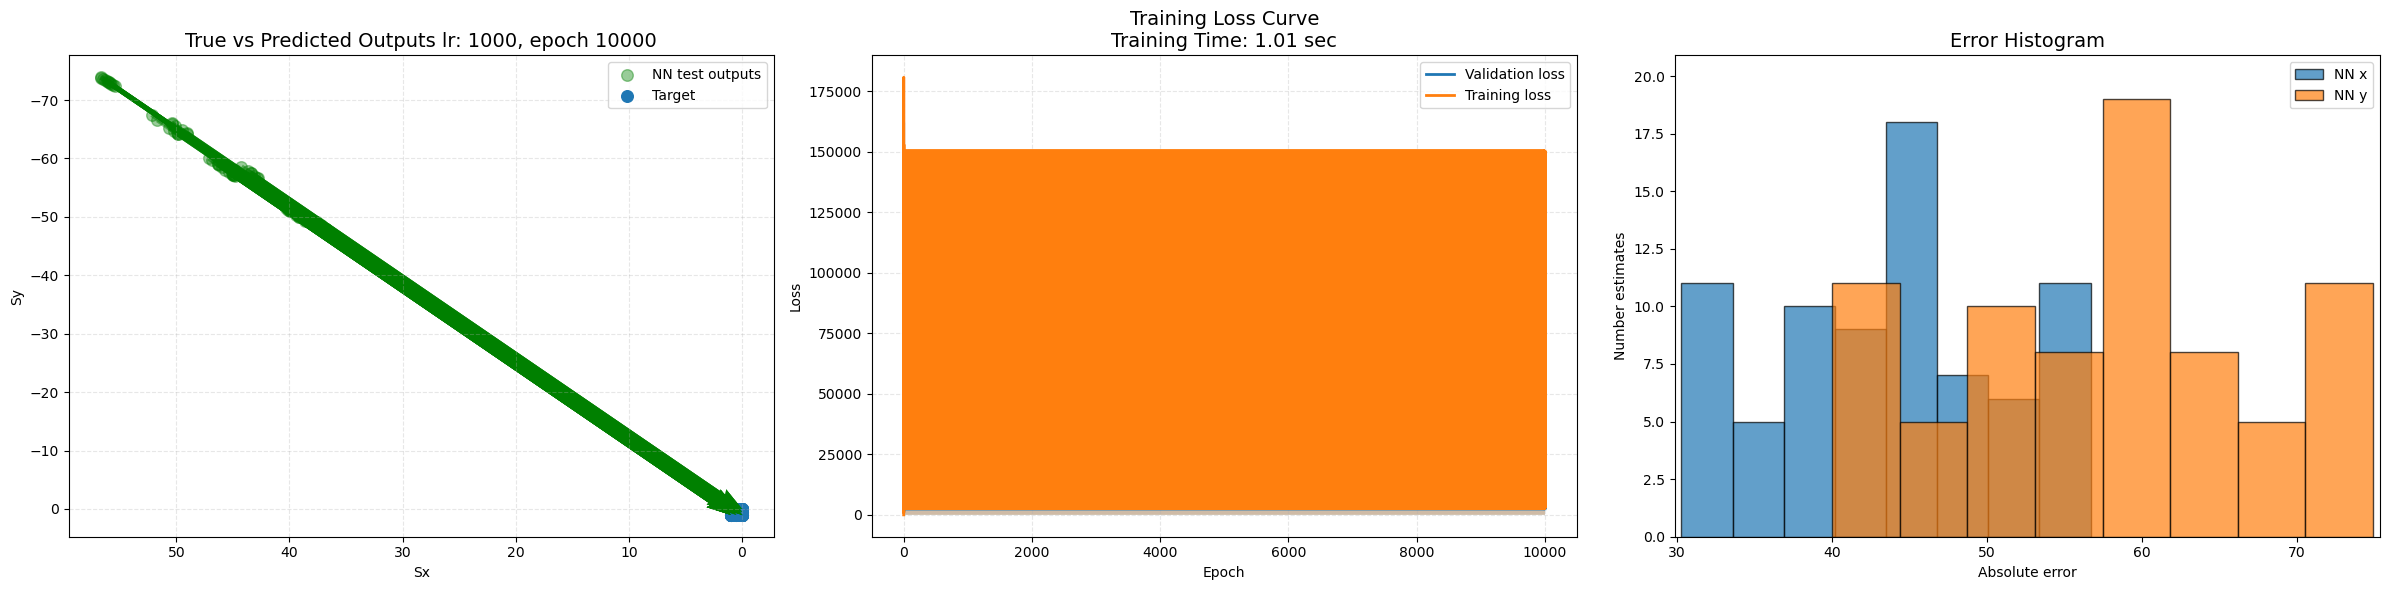

In [ ]:
class DataScaler:
    def __init__(self, data):
        self.data = data
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)

    def normalize(self, data=None):
        if data:
            normalized_data = (data-self.min)/(self.max-self.min)
        else:
            normalized_data = (self.data-self.min)/(self.max-self.min)

        return normalized_data

    def denormalize(self, normalized_data):

        data = normalized_data * (self.max - self.min) + self.min   
        return data
    


# Set hyperparameters
input_dim = 2
output_dim = 2
learning_rate = [0.0001, 0.1, 1.5, 1000]
epoch = [2, 500, 2000, 10000]
criterion = MSELoss()

pupil_data_scaler = DataScaler(input)
screen_data_scaler = DataScaler(labels)

norm_pupil = pupil_data_scaler.normalize()
norm_screen = screen_data_scaler.normalize()

# Containers gaze data
models_dict = {}
losses_train_dict = {}
losses_val_dict = {}
training_time_dict = {}
pred_norm_dict = {}
errors_norm_dict = {}
mse_norm_dict= {}

X_train, X_test, Y_train, Y_test = train_test_split(norm_pupil, norm_screen, train_size=0.80, test_size=0.20)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.75, test_size=0.25)

# idk tensors go brrrr
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)  
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)   

nn_util.plot_data_splits(X_train, X_val, X_test)



#Train the models
for i in learning_rate:
    for j in epoch:
        name = f"lr: {i}, epoch {j}"
        new_model = LinearModel(input_dim, output_dim)
        new_optimizer = optim.SGD(new_model.parameters(), lr=i)

        losses, val_losses, training_time = train_model(new_model, criterion, new_optimizer, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, num_epochs=j)

        mse, Y_pred_lm, true_values, errors_nn = test_model(new_model, X_test_tensor, Y_test_tensor)

        models_dict[name] = new_model
        losses_train_dict[name] = losses
        losses_val_dict[name] = val_losses
        training_time_dict[name] = training_time
        pred_norm_dict[name] = Y_pred_lm
        errors_norm_dict[name] = errors_nn
        mse_norm_dict[name] = mse



nn_util.plot_mse_bar(mse_norm_dict)
nn_util.plot_results_collected(Y_test, pred_norm_dict, errors_norm_dict, models_dict, losses_train_dict, losses_val_dict, training_time_dict)


---
**Task 8 (easy): Reflection on results💡**
1. What is the impact of normalizing the data and why?
2. Experiment with the hyperparameter settings in the `learning_rate`
 and number of `epoch`
 lists.
3. What are the benefits and cost of training with larger/smaller learning rate? Reflect on the effect of changing the learning rate.
4. Reflect on the effect of the loss and training time when changing the number of epochs. 
5. What is the relationship between learning rate and epochs? 
6. The network architecture mimics the charateristics of a linear model, explain why the network architecture in many instances performs much different (and worse) compared to the linear least square?


---

In [0]:
# Write your reflections here...
"""
1. Normalizing the data will make sure out NN is better at making small adjustments since our values are smaller
2. yes we did
3. You will learn quicker so you need less epochs to reach a minimum but you might overshoot if its too high 
4. The more epochs the longer it takes, if you hit the minimum early you don't see any benifit from more epochs
5. Key Trade-offs:

    High LR + Few Epochs
    → Quick but risky (may overshoot optimum)

    Low LR + Many Epochs
    → Precise but slow (guaranteed convergence)

    High LR + Many Epochs
    → Likely divergence (unstable)

    Low LR + Few Epochs
    → Insufficient learning (underfitting)

6. See previous exercise (task 6)
"""

## Non-linear Model
The following steps are about two different architectures for non-linear models. Compare the non-linear models to the affine model as done above. 

---
**Task 9 (easy): Analyse architecture💡**
1. Examine the cell below to get an overview of the two model architectures and identify the main differences between the models.


---

In [40]:
class NNRelu(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NNRelu, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()
 
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        return x
 
class NNRelu_exp(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NNRelu_exp, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim, output_dim)
 
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

In [0]:
# Write your reflections here...
"""
First the NNRelu is a linear model with the relu activation function
The NNRelu_exp is a non-linear model with 2 hidden layers all using relu activation function 
"""


---
**Task 10 (easy): Train non-linear models (cleaned gaze data)👩‍💻**
**Note:** For the exam it may be convenient to copy the code from above to the cell below as you complete the steps. 

1. Rerun task [Task 7](#prediction100) using the normalized to train two new models. The steps are:

- Train the models:
    - Create two nested for-loops looping the lists containing hyperparameter values for `learning rate`
 and `epochs`
. The loops should:        - Train models of both architectures on the cleaned normalized data, using the `train_model`
 function.
        - Test the models using the `test_model`
 function.
        - Save the following information in the designated dictionaries with the suffix `arc`
, for each model:            - Model 
            - Loss (training)
            - Loss (validation)
            - Training time 
            - Predictions
            - Errors 






- Use the function `plot_results_collected`
 from the `nn_util.py`
 file, to visualize the result.

- Use the function `plot_mse_bar`
 from the `nn_util.py`
 file, to visualize the mean squared error compared.



---

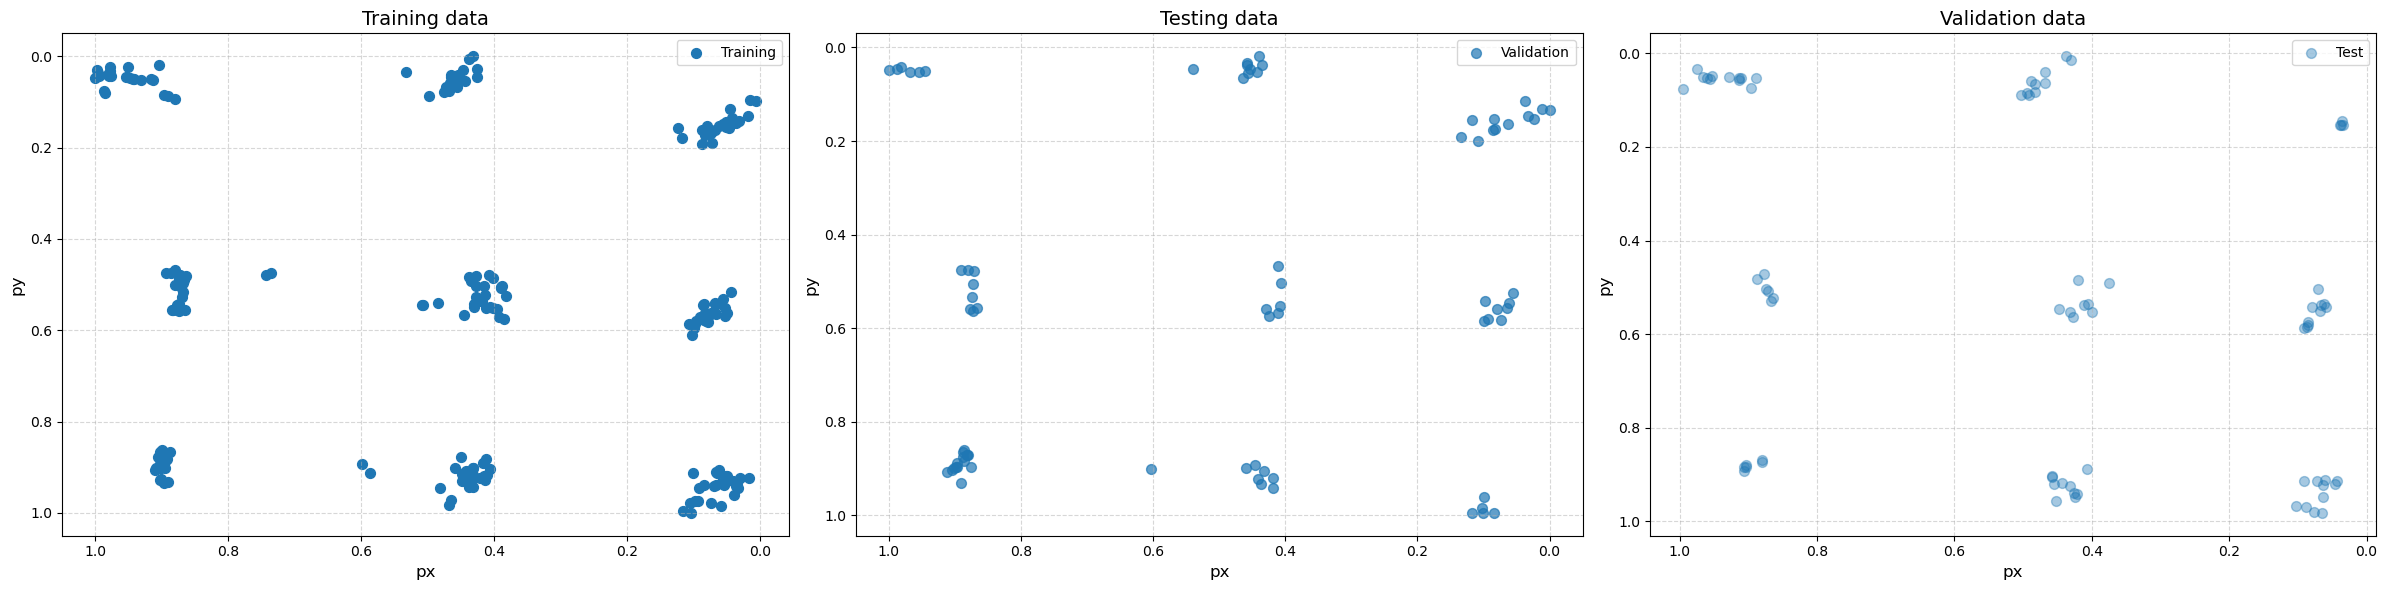

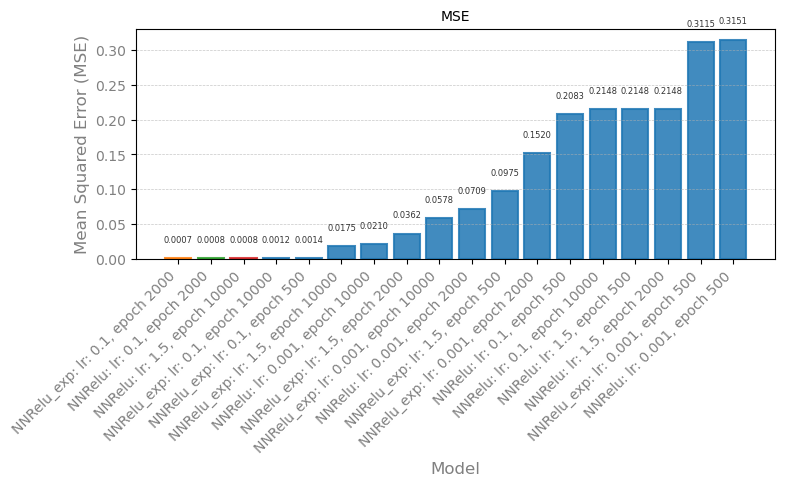

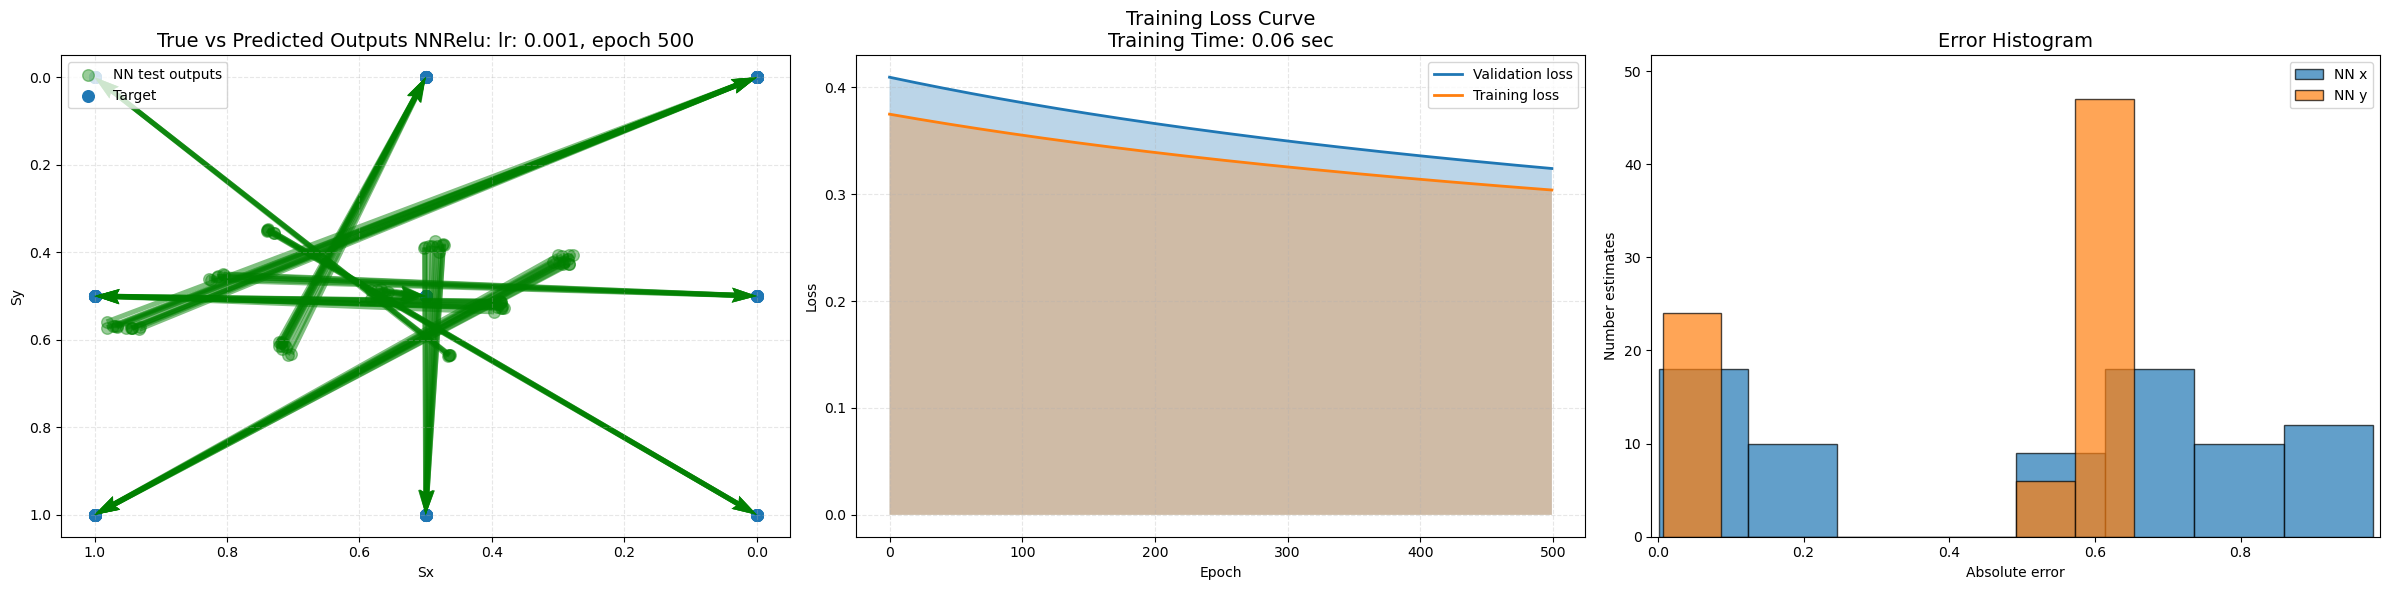

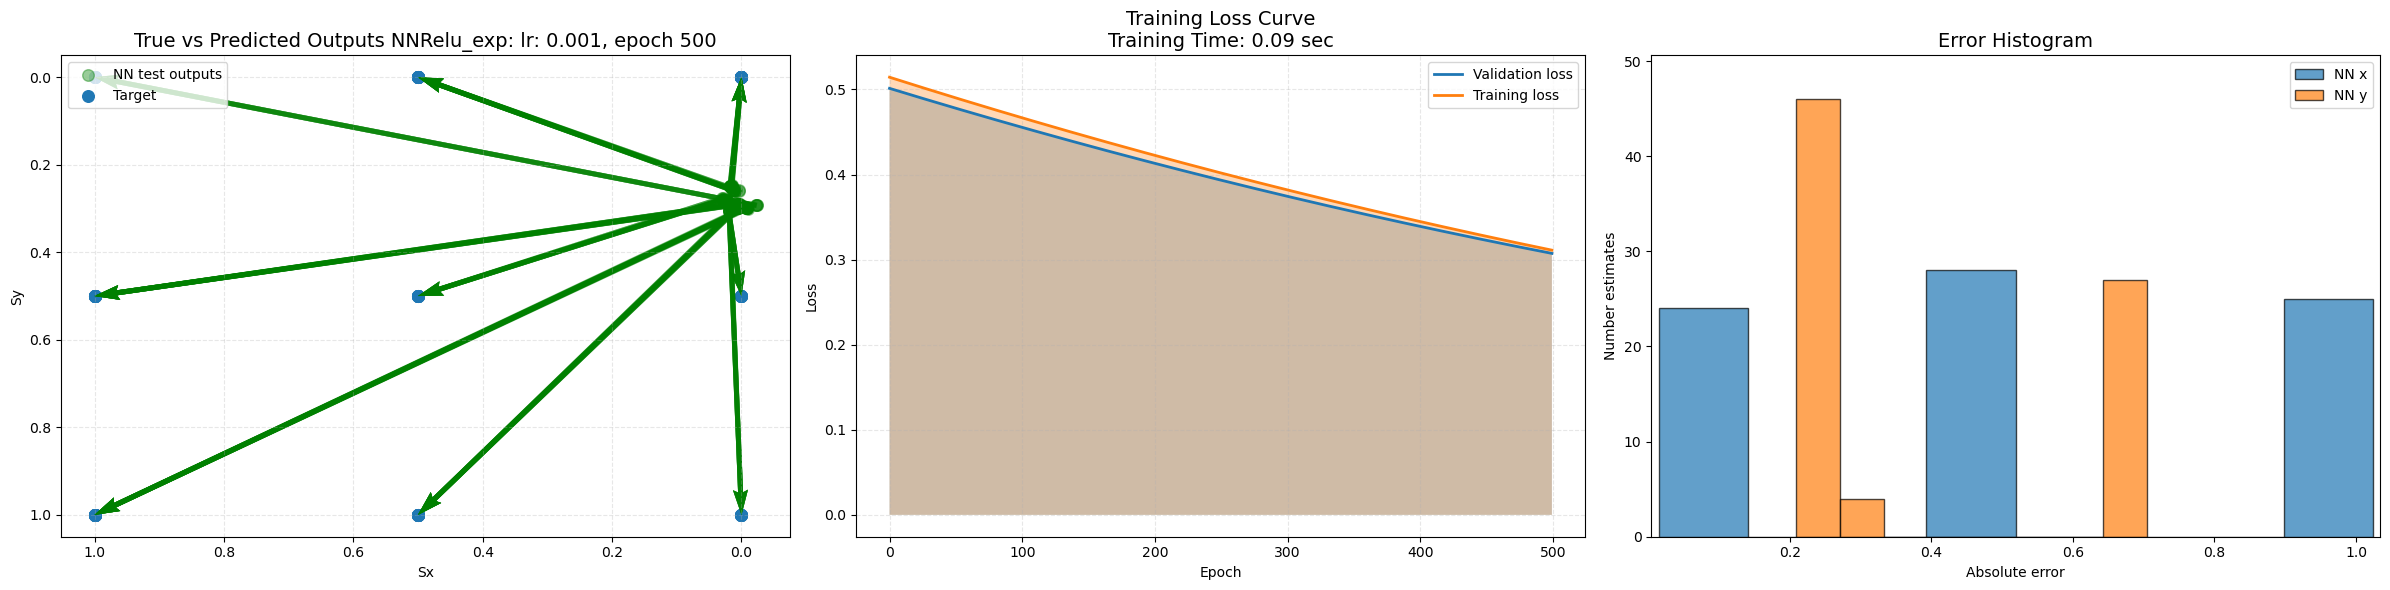

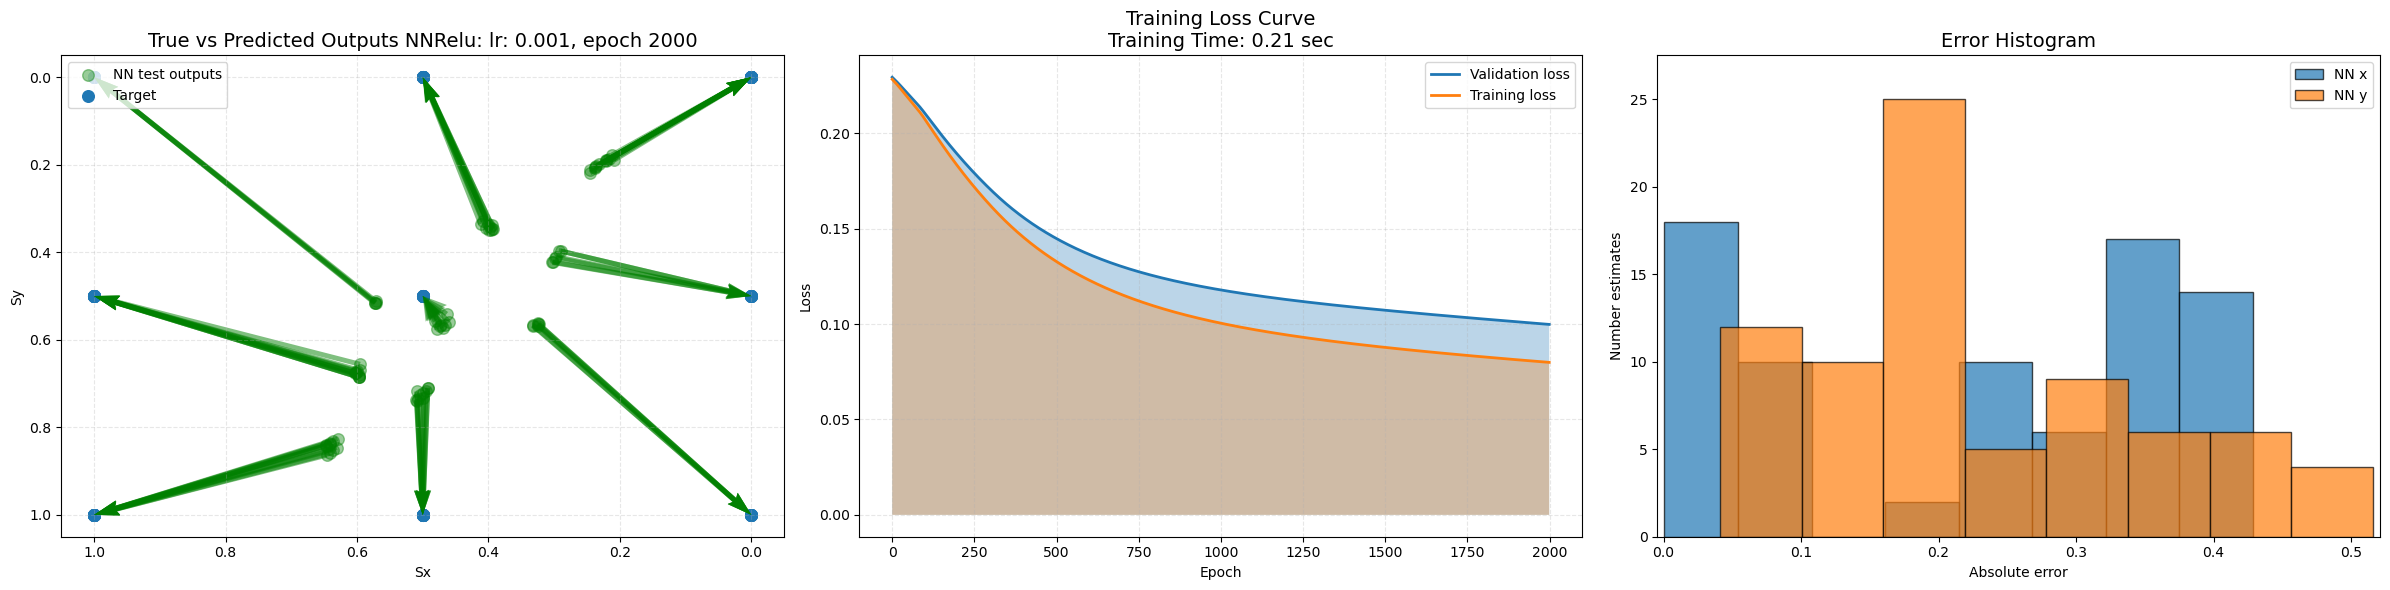

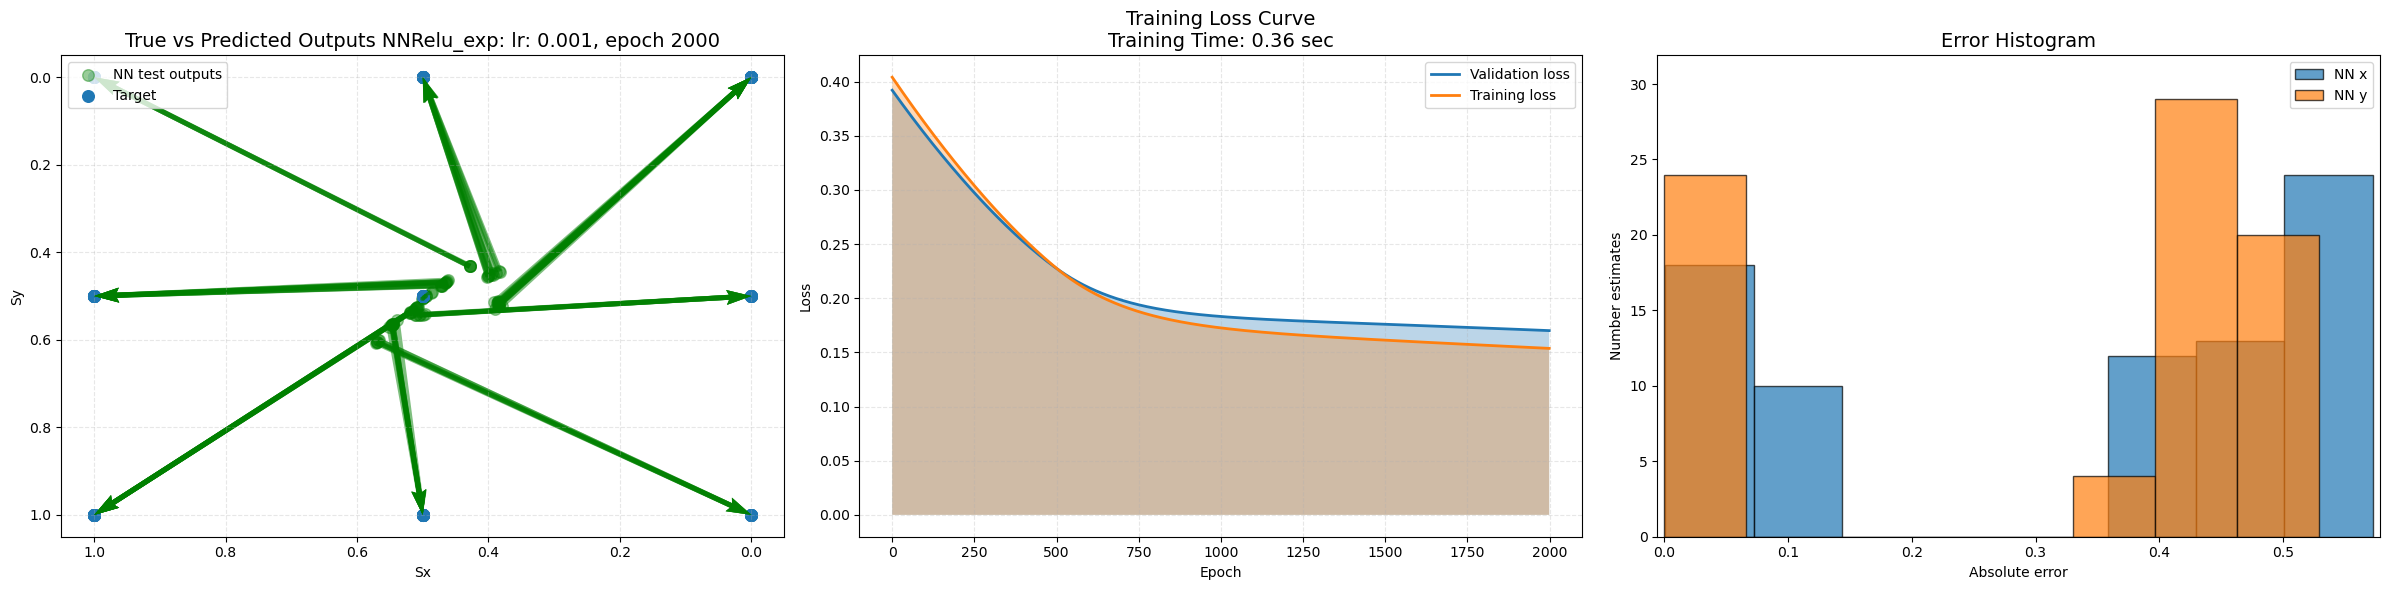

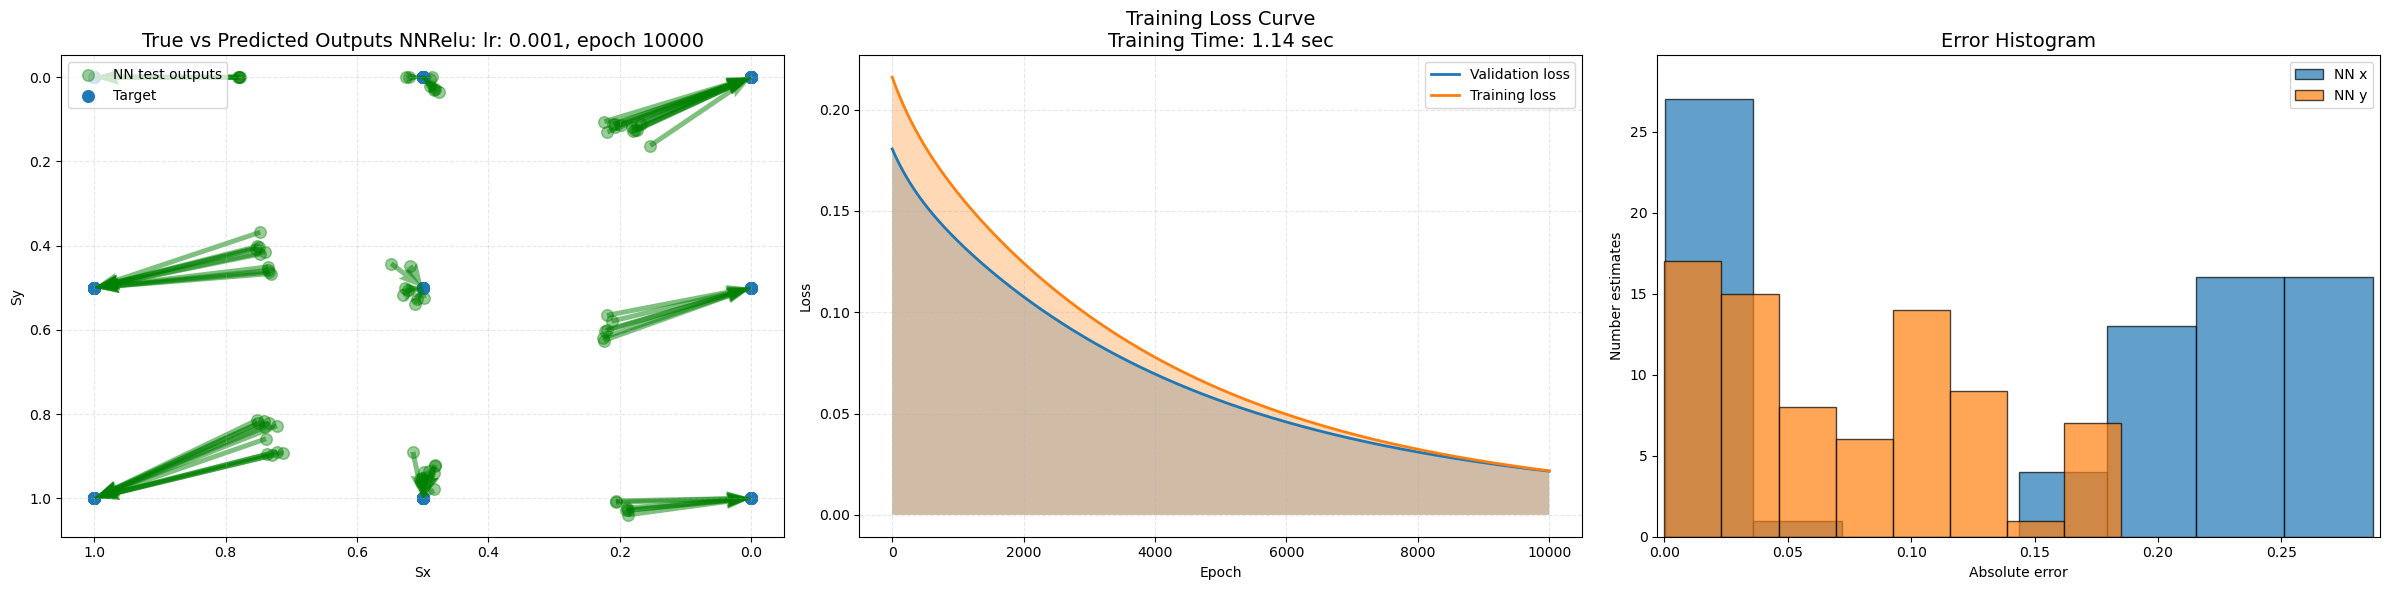

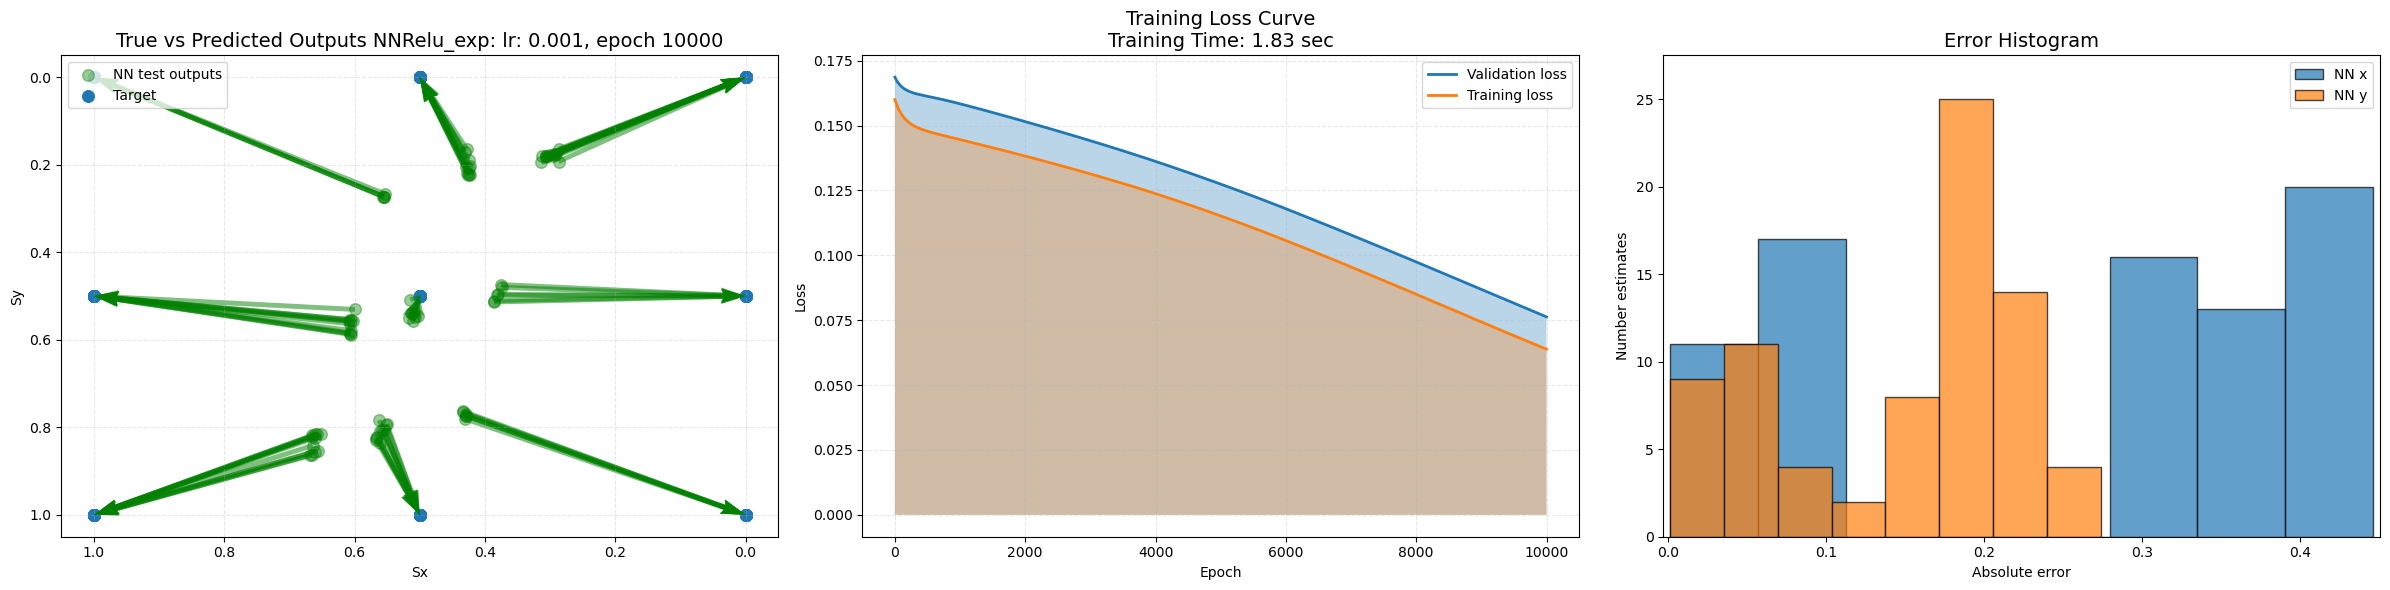

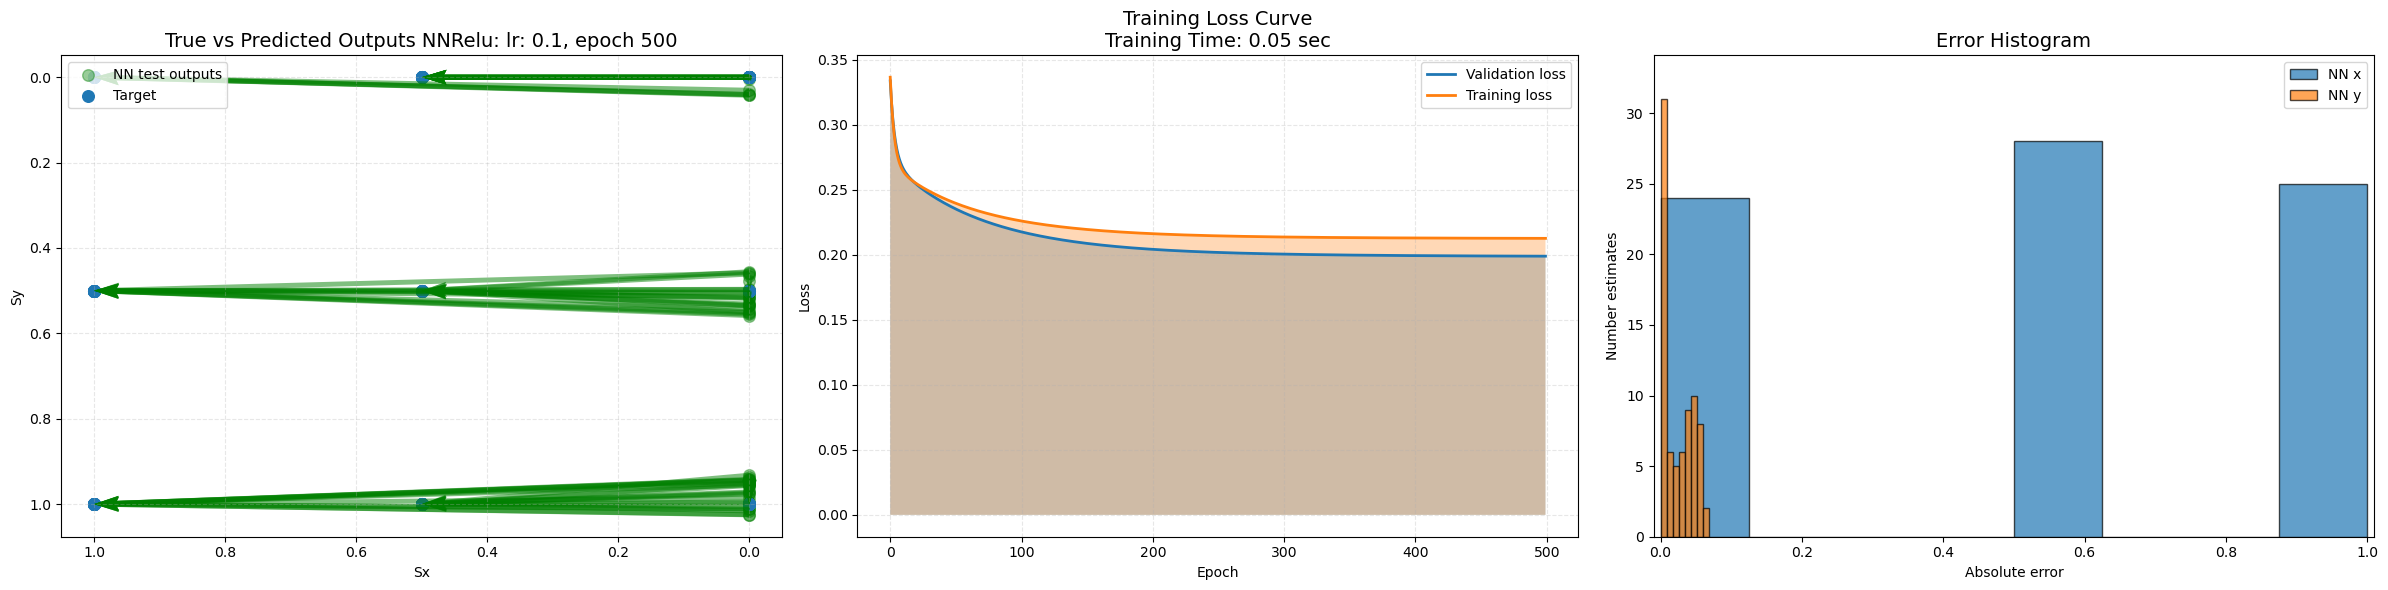

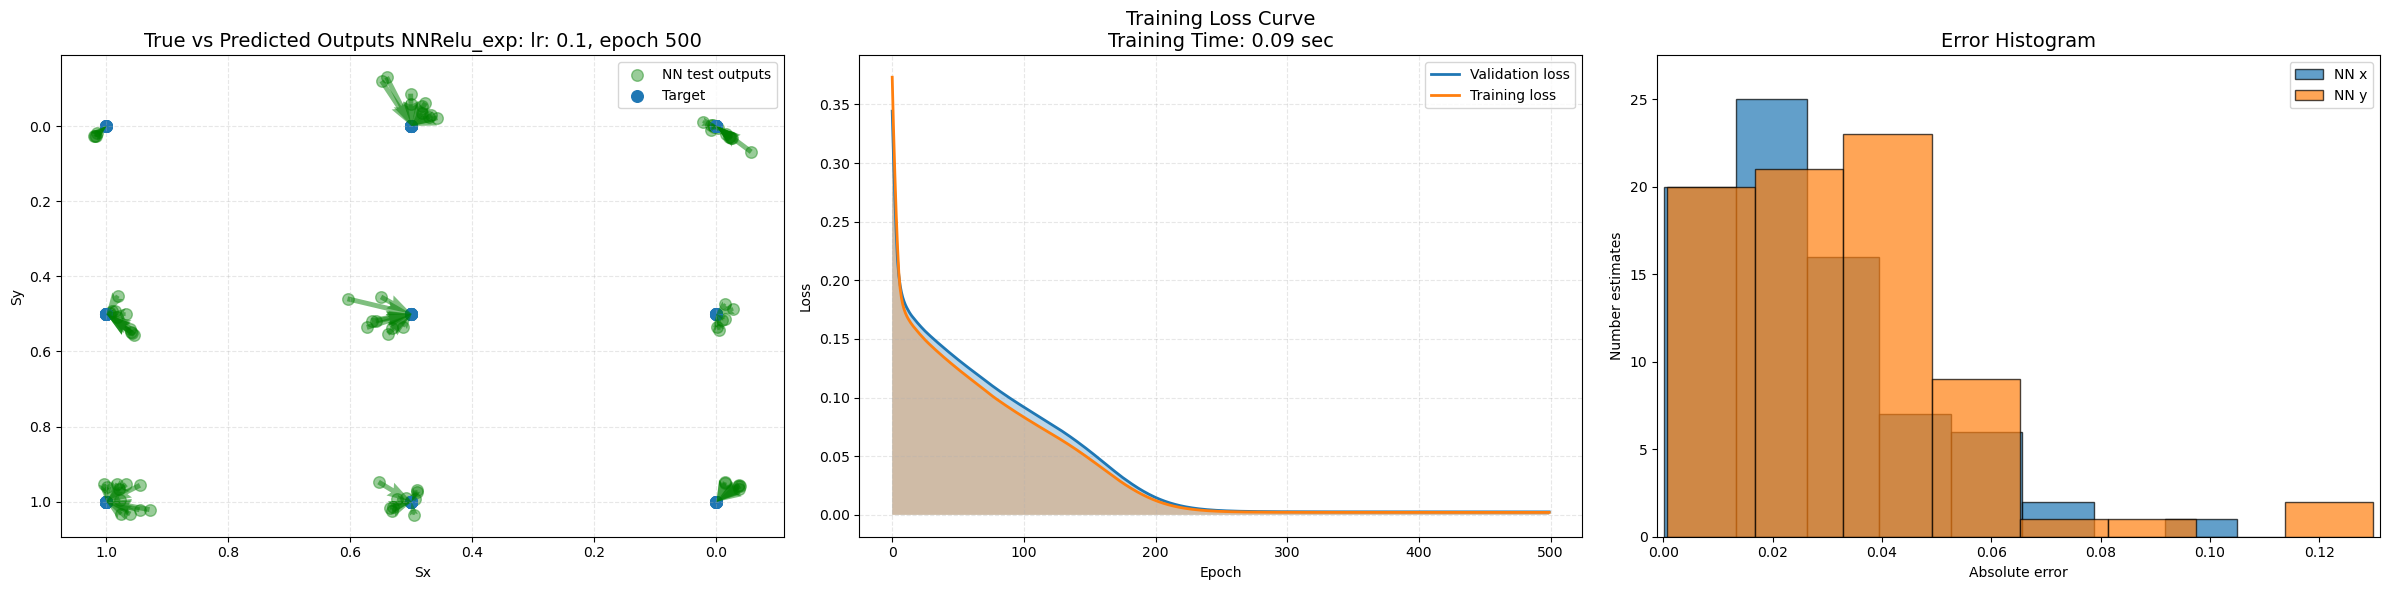

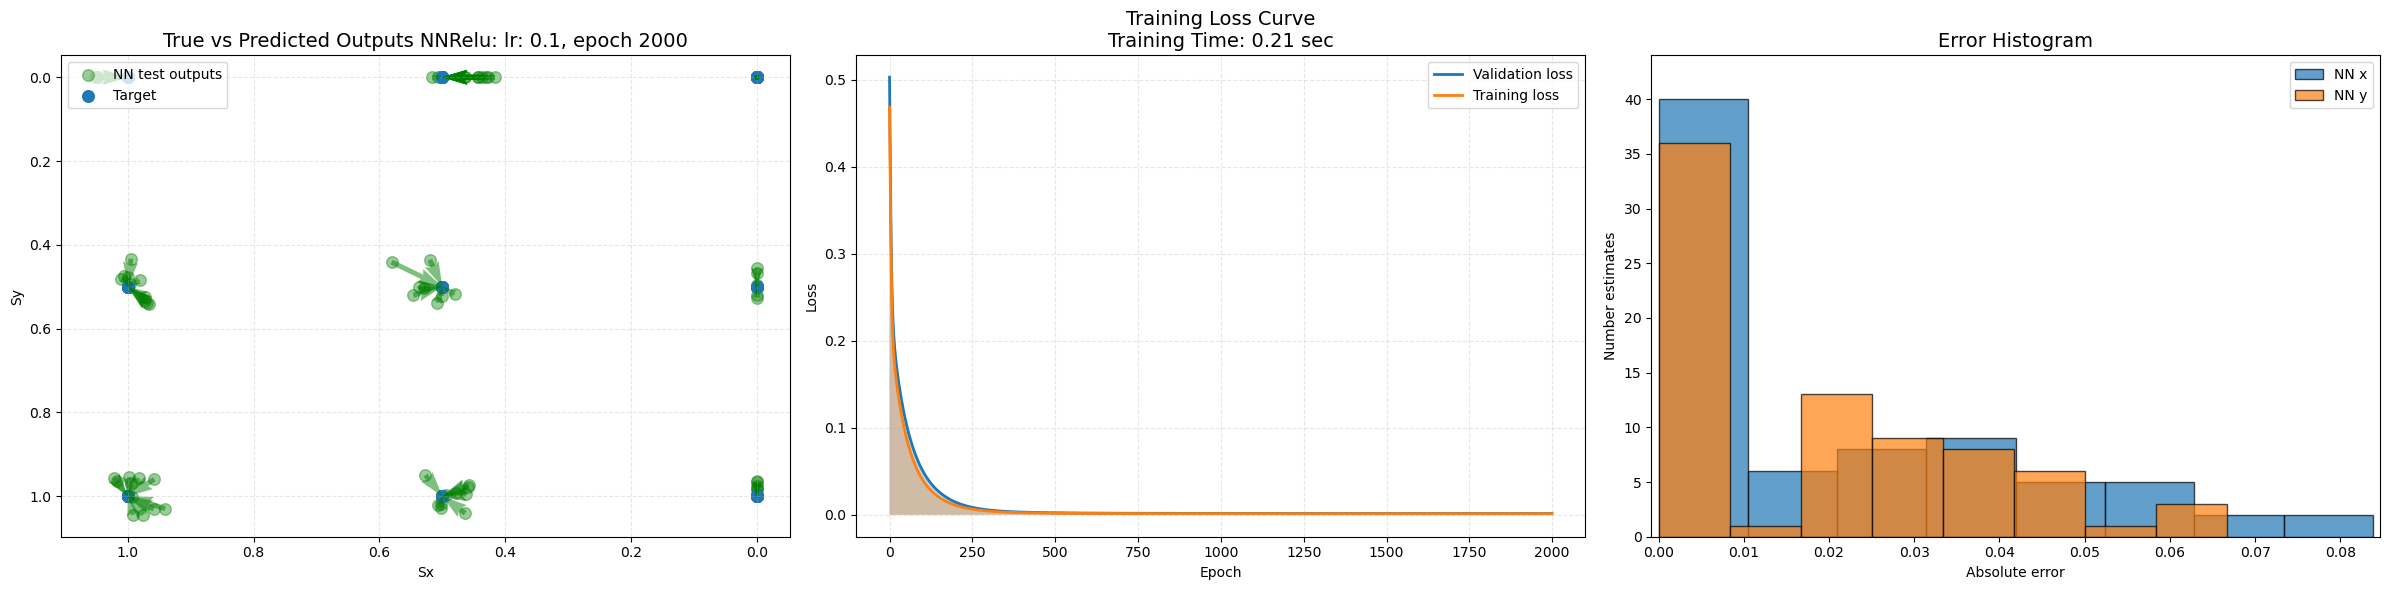

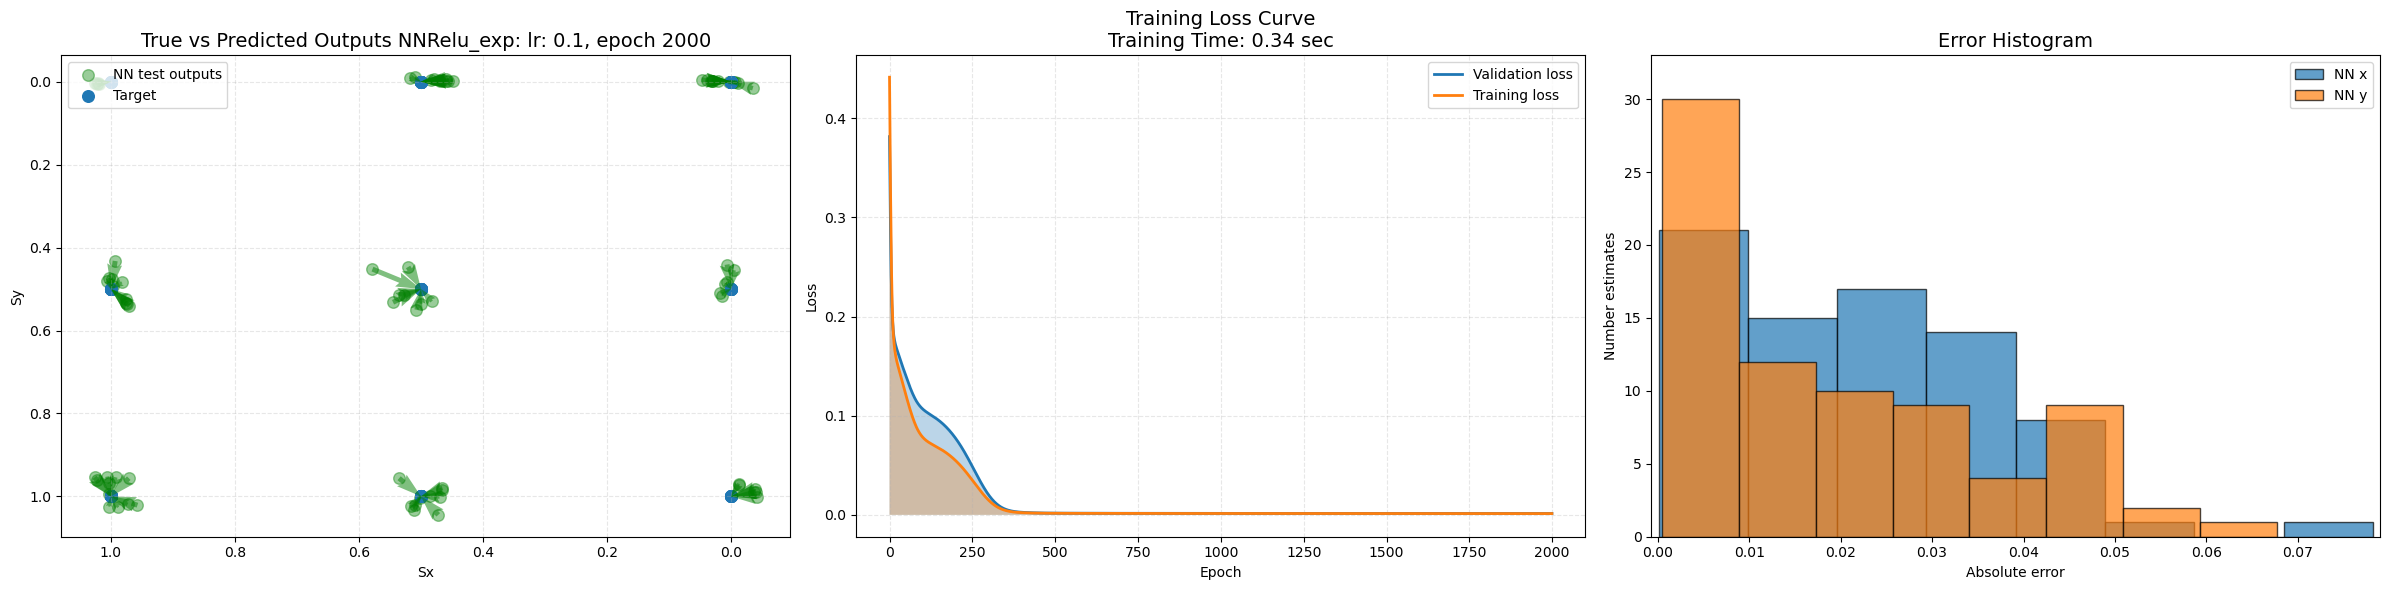

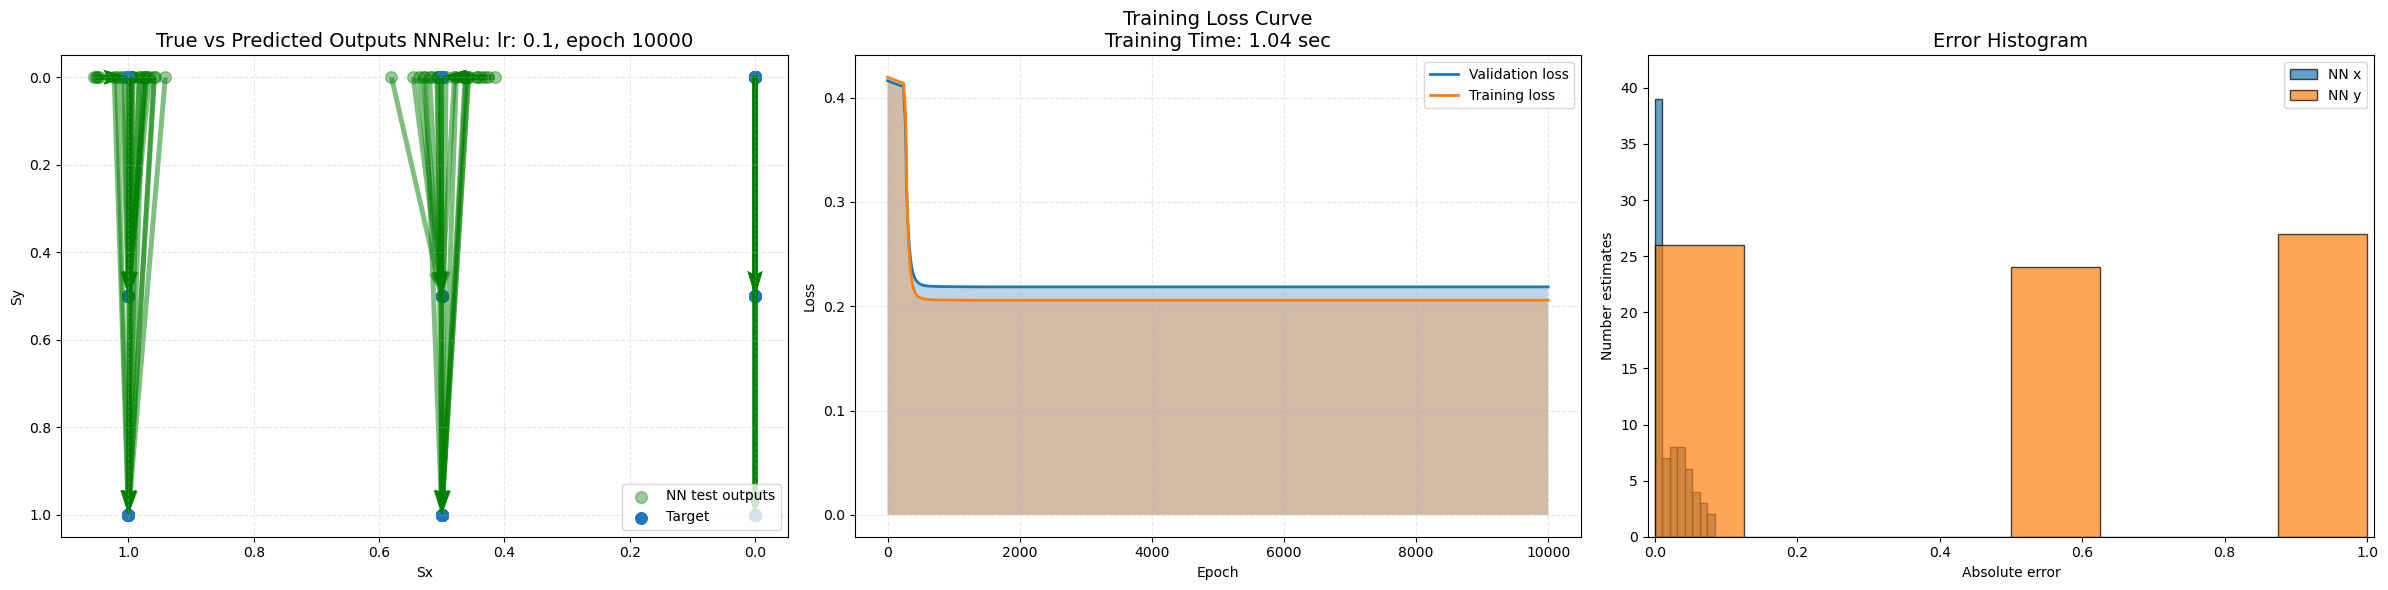

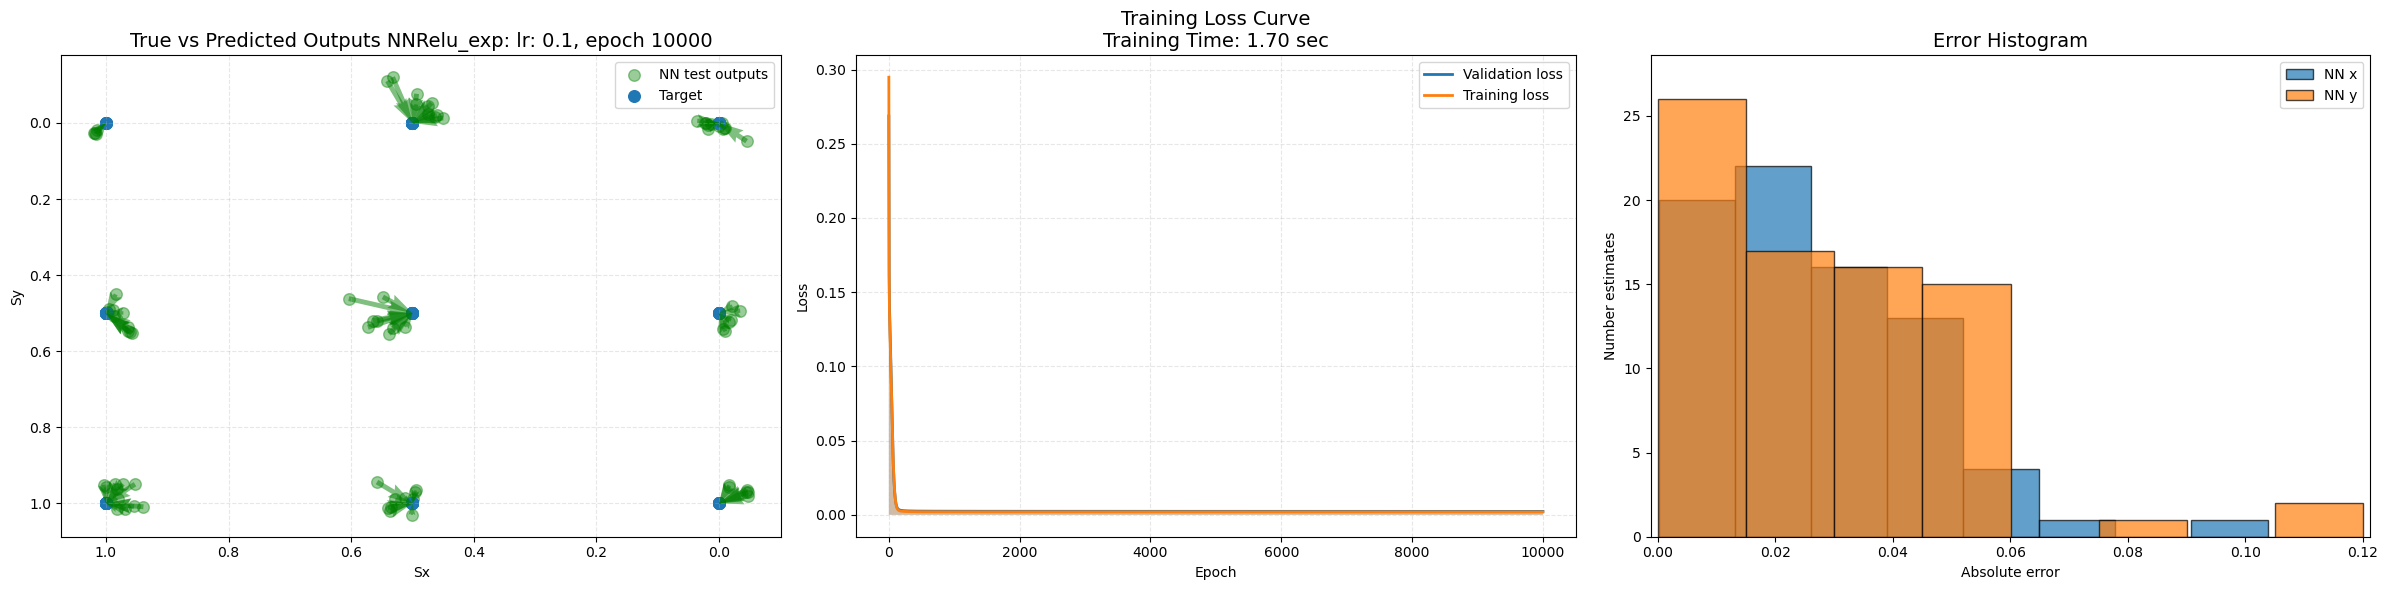

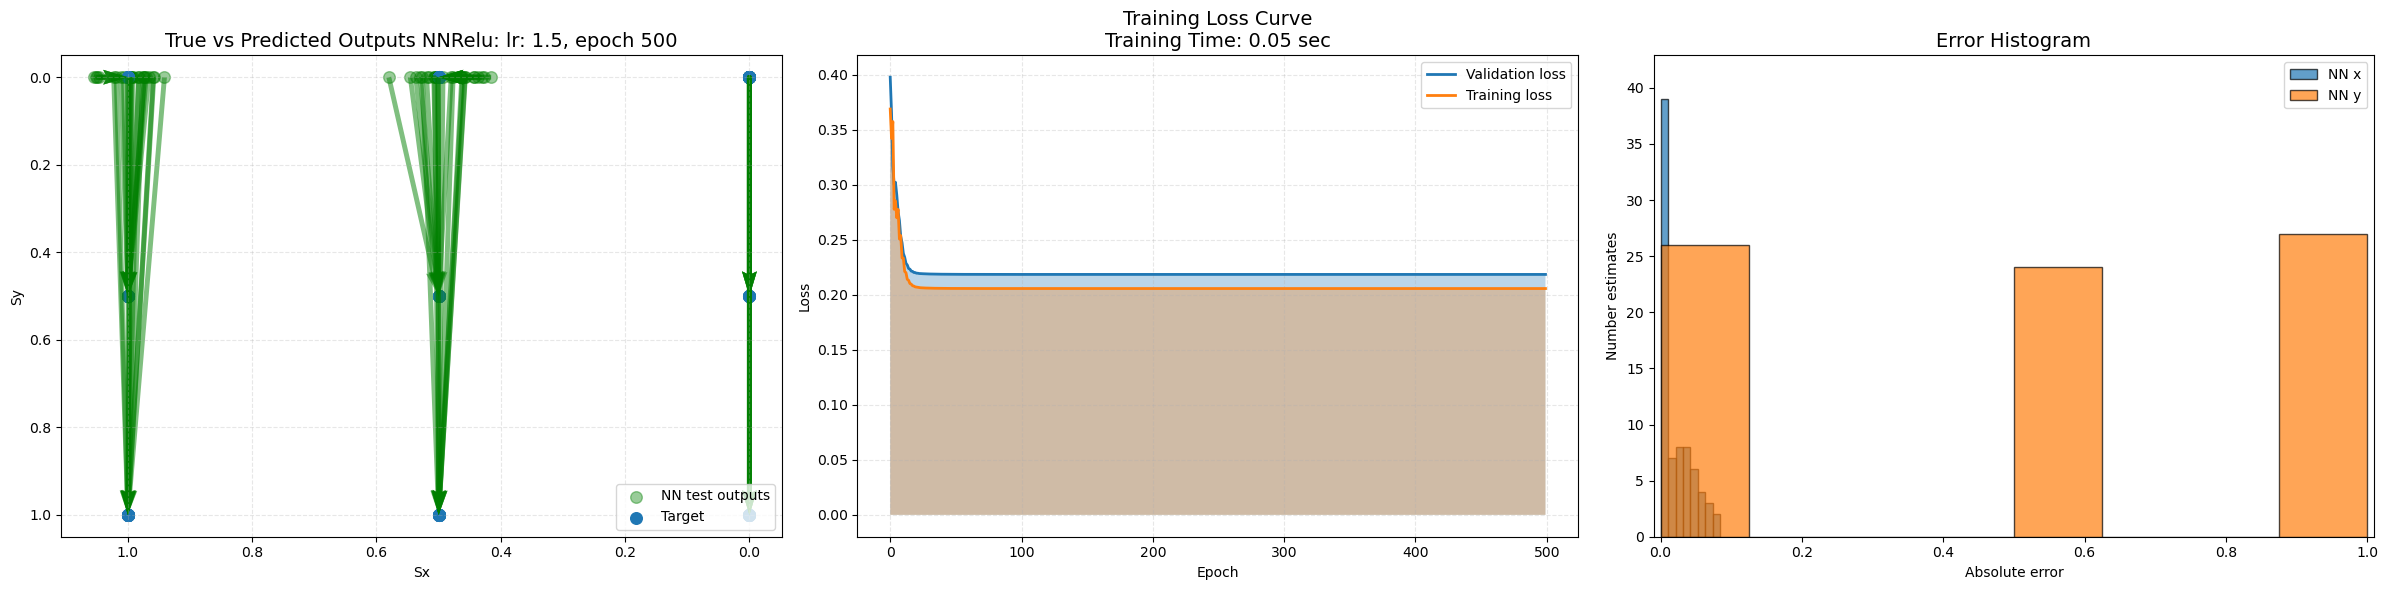

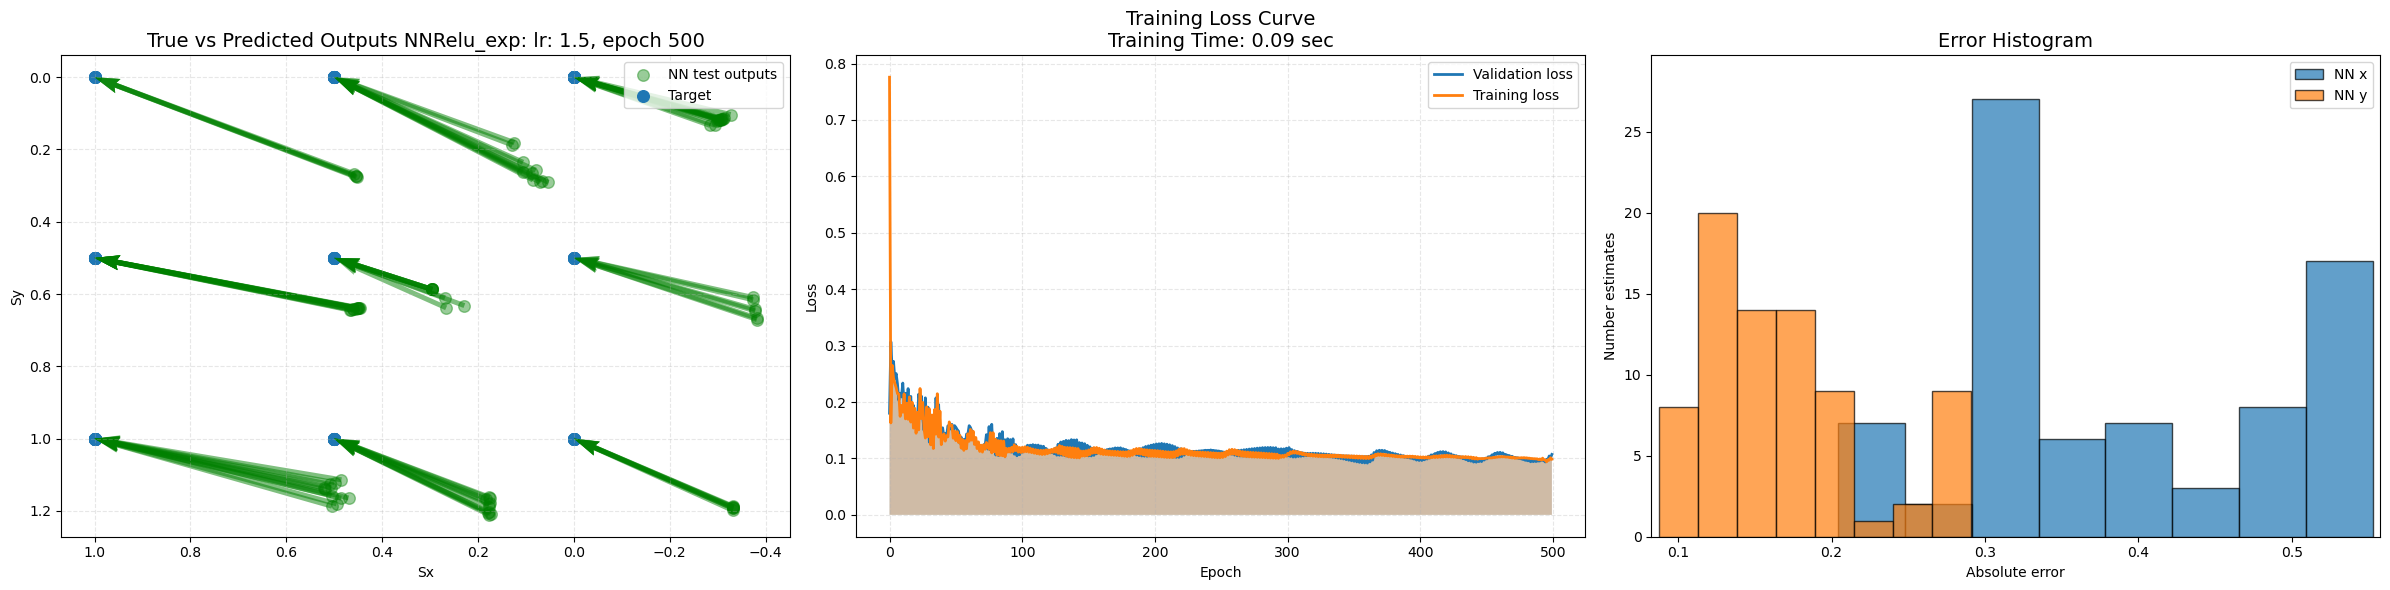

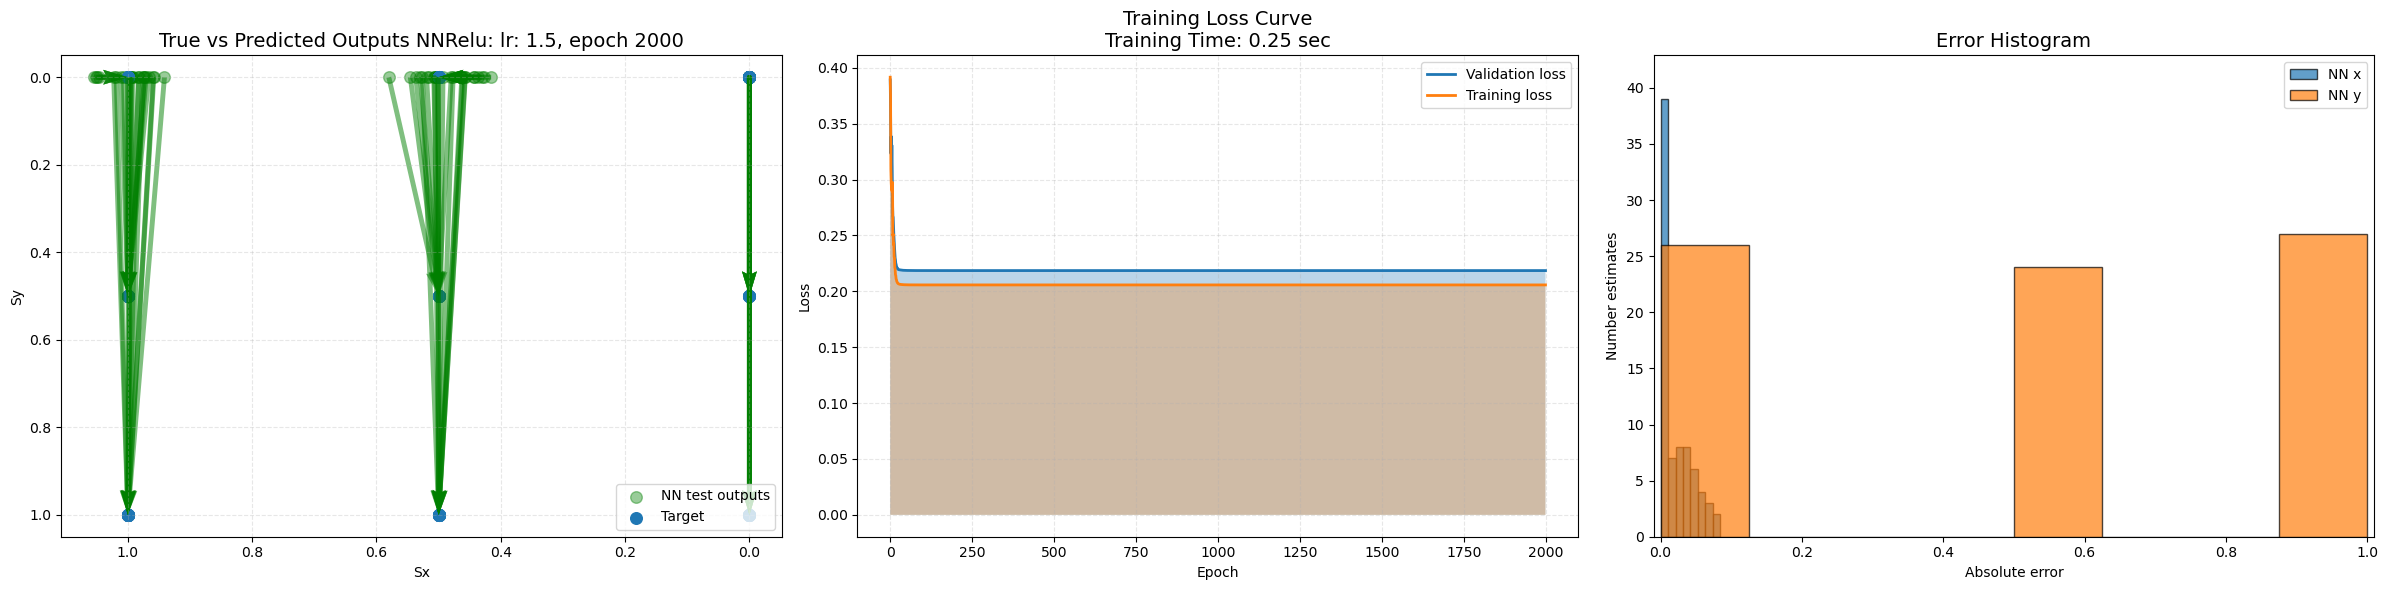

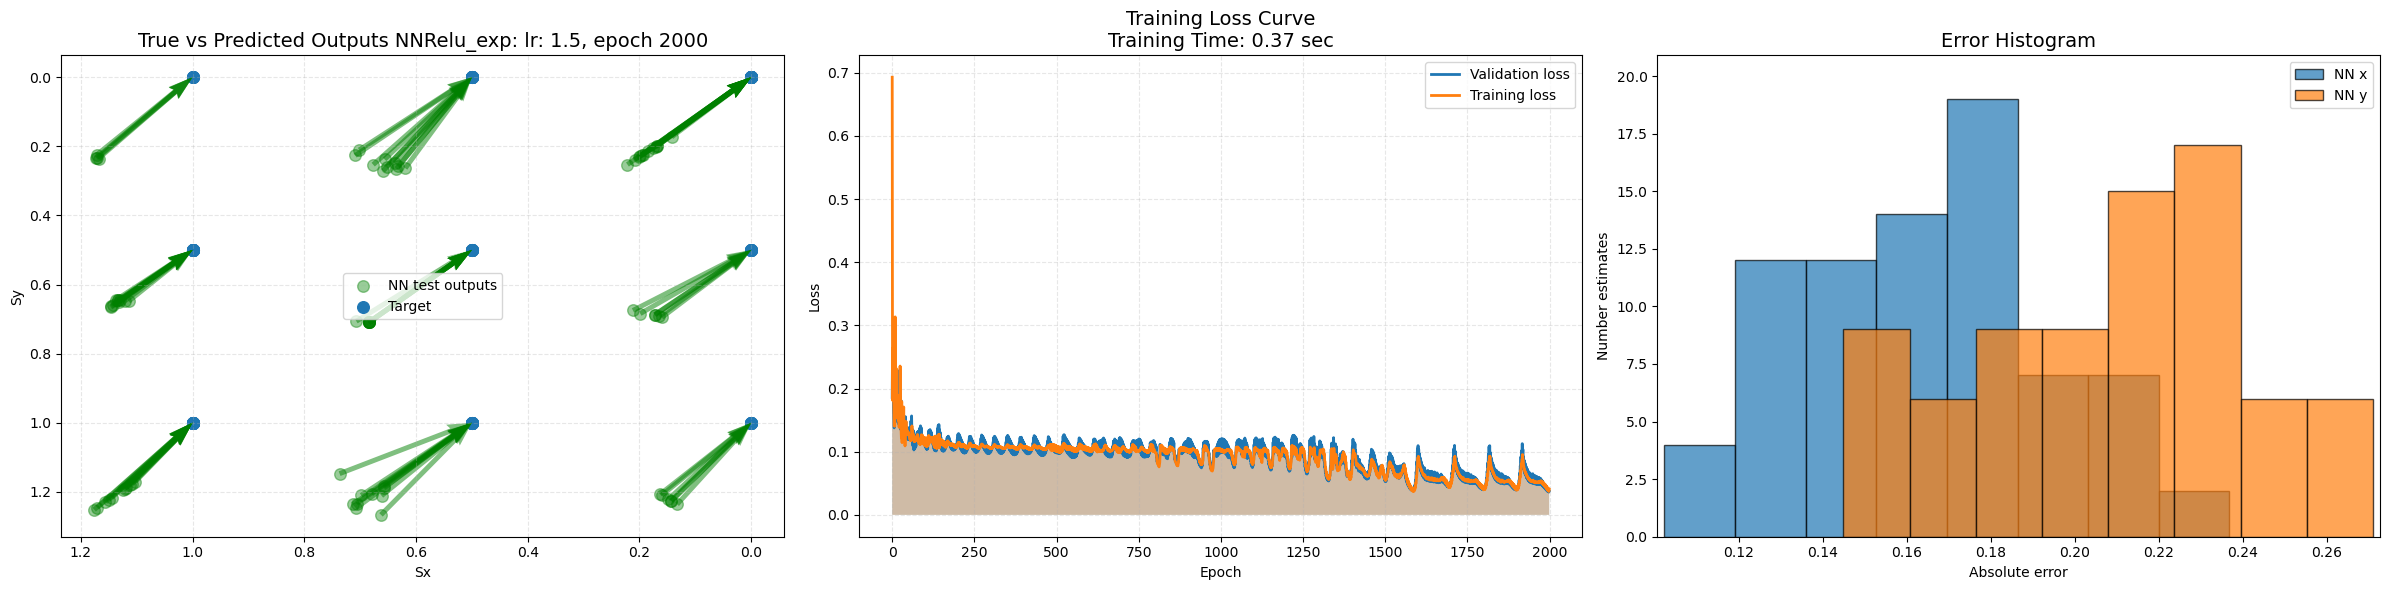

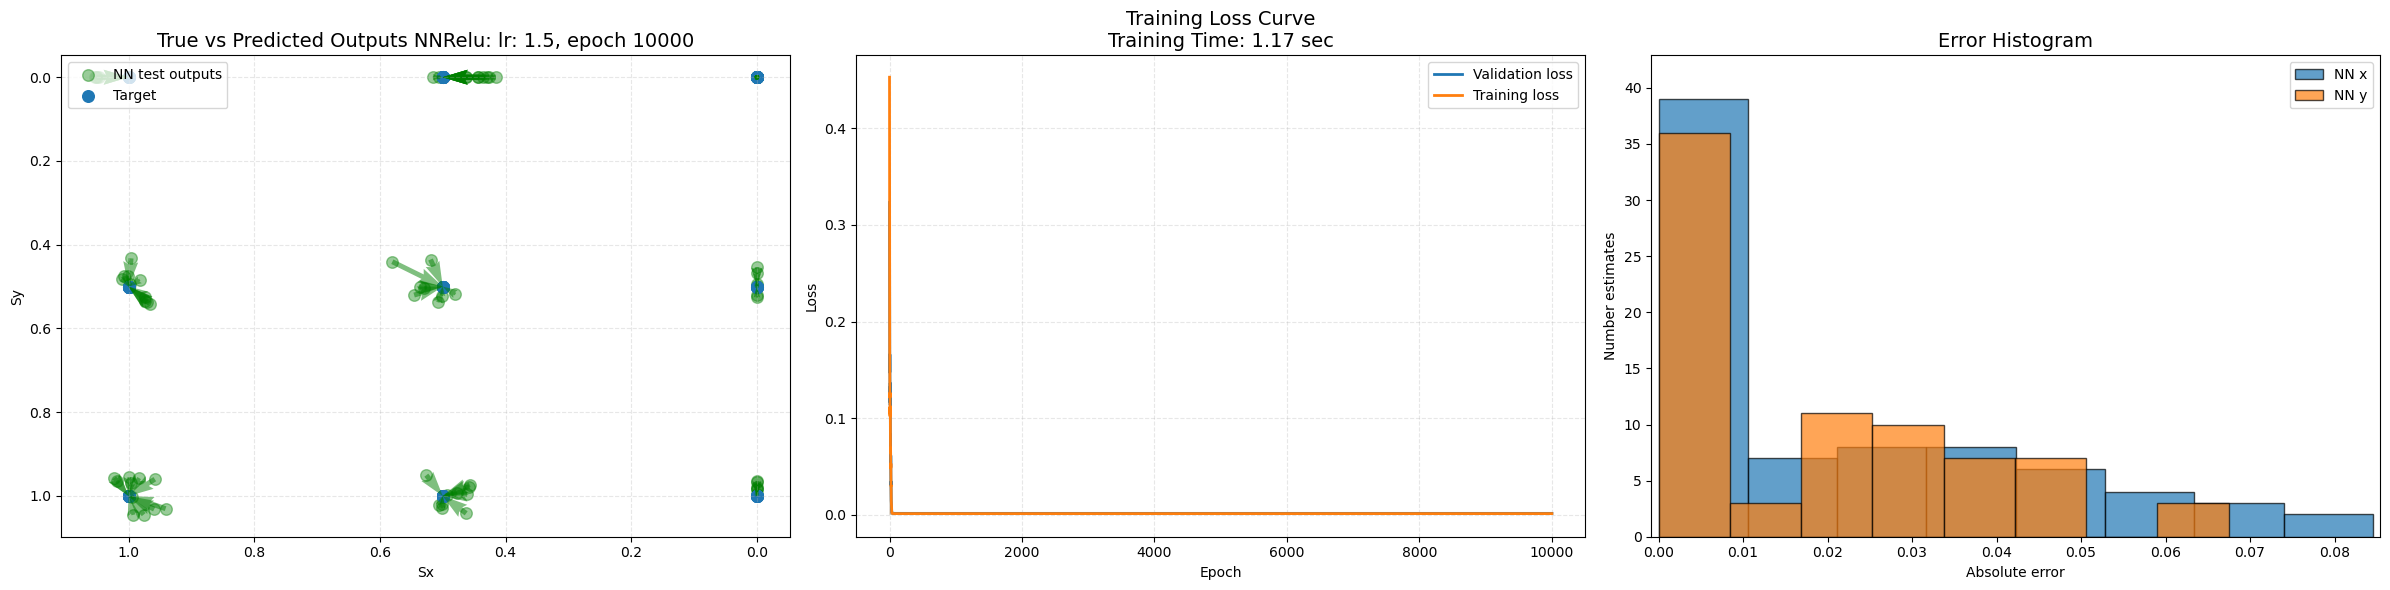

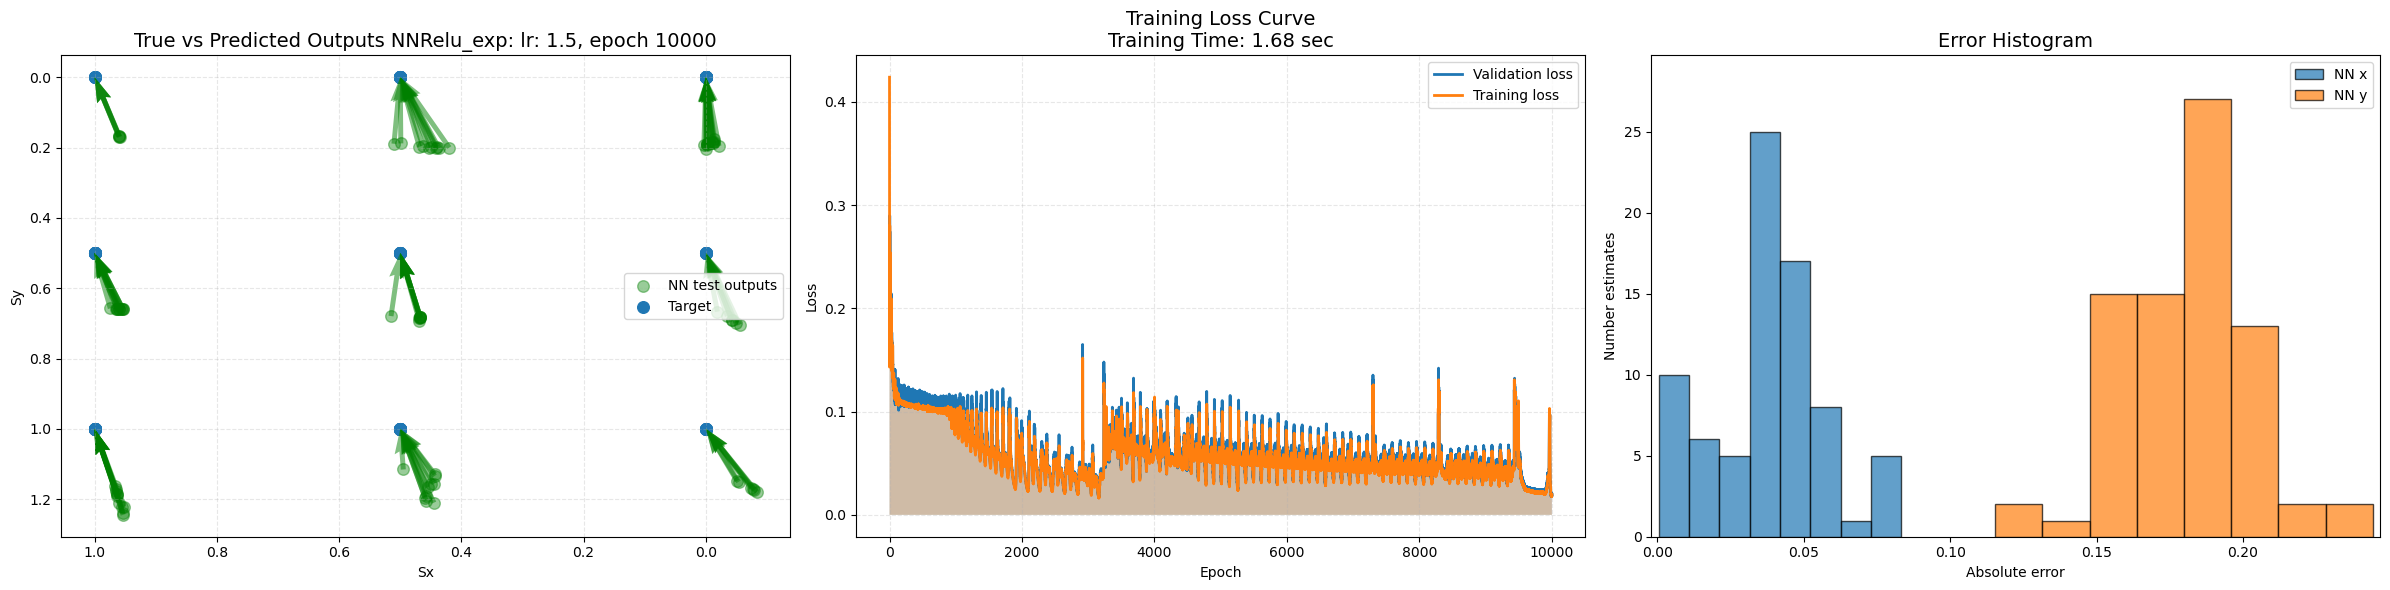

In [42]:
# Set hyperparameters
input_dim = 2
output_dim = 2
learning_rate = [0.001, 0.1, 1.5]
epoch = [500, 2000, 10000]
hidden_layer = 10

criterion = MSELoss()


pupil_data_scaler = DataScaler(input)
screen_data_scaler = DataScaler(labels)

norm_pupil = pupil_data_scaler.normalize()
norm_screen = screen_data_scaler.normalize()

X_train, X_test, Y_train, Y_test = train_test_split(norm_pupil, norm_screen, train_size=0.80, test_size=0.20)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.75, test_size=0.25)

# idk tensors go brrrr
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)  
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)   

nn_util.plot_data_splits(X_train, X_val, X_test)

models_dict_arc = {}
losses_dict_arc = {}
losses_val_dict_arc = {}
training_time_dict_arc = {}
pred_norm_arc = {}
errors_norm_arc = {}
mse_arc = {}


#Train the models
for i in learning_rate:
    for j in epoch:
        for model in [NNRelu, NNRelu_exp]:
            name = f"{model.__name__}: lr: {i}, epoch {j}"
            if model == NNRelu_exp:
                new_model = model(input_dim, hidden_layer, output_dim)
            else:
                new_model = model(input_dim, output_dim)
            new_optimizer = optim.SGD(new_model.parameters(), lr=i)

            losses, val_losses, training_time = train_model(new_model, criterion, new_optimizer, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, num_epochs=j)

            mse, Y_pred_lm, true_values, errors_nn = test_model(new_model, X_test_tensor, Y_test_tensor)

            models_dict_arc[name] = new_model
            losses_dict_arc[name] = losses
            losses_val_dict_arc[name] = val_losses
            training_time_dict_arc[name] = training_time
            pred_norm_arc[name] = Y_pred_lm
            errors_norm_arc[name] = errors_nn
            mse_arc[name] = mse

nn_util.plot_mse_bar(mse_arc)
nn_util.plot_results_collected(Y_test, pred_norm_arc, errors_norm_arc, models_dict_arc, losses_dict_arc, losses_val_dict_arc, training_time_dict_arc)



---
**Task 11 (easy): Reflect on the results💡**
1. Do more/less complex models improve the result? Why/why not?
2. Are there indications of overfitting in any of the models?


---

In [0]:
# Write your reflections here...
"""
1. In some cases it does one of our models is dead on (Relu lr: 1.5 epoch: 10000) is hella nice
2. Yes some of the models seem to be overfitting, where we see a gap or even an expanding gap between the validation and the training data
 (e.g. Relu lr:0.1 epoch: 10000)
"""


---
**Task 12 (easy): Analyse results💡**
1. Experiment with other architectures by suggesting models with different number layers and neurons in each layer.
**Note:** This part of the exercise can easily become a timesink, mind your time as you proceed.


2. Reflect on the results    - Do more/less complex models improve the result? Why/why not?
    - Do any of the models show signs of overfitting?




---

In [0]:
# Write your reflections here...


## Own dataset
Experiment with your own dataset and other models. 
**Note:** For the exam it may be convenient to copy your code from task [Task 7](#prediction100) to the cell below.
This part of the exercise can easily become a timesink, mind your time as you proceed.


---
**Task 13 (easy): Train models (own dataset)👩‍💻💡**
1. Experiment with your own dataset. 
2. Reflect on your results, compare to the results of `test_subject_1`
. 


---

In [0]:
# Write your reflections here...